In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import os
from copy import deepcopy

import h5py

import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [3]:
def compute_tau(X, theta, eps=1e-12):
    N = X.shape[0]
    K = len(theta.pi)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = norm(theta.mu[k], np.sqrt(theta.sigma[k]))
        for i in range(N):
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i, :])
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [4]:
def compute_stat(X, Z):
    N = X.shape[0]
    K = Z.shape[1]
    D = X.shape[1]

    s1 = np.sum(Z, axis=0, keepdims=True)
    s2 = X.T.dot(Z).T
    s3 = np.einsum('ijk,il->ljk' , np.array([np.outer(X[i, :], X[i, :])  for i in range(X.shape[0])]), Z)
    
    return s1, s2, s3

In [5]:
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)

    return pi, mu, sigma

In [6]:
class SuffStat:
    def __init__(self):
        pass

In [7]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.dirichlet([1.0]*K).reshape(-1, 1)
        self.s2 = np.random.random((K, D))
        self.s3 = np.random.random((K, D, D))

In [8]:
def calc_falarms_benefit(scores, change_points, start=None, end=None, h=100, T=100, N_thr=100, eps=1e-2):
    scores_max, scores_min = np.nanmax(scores), np.nanmin(scores)
    threshold_list = np.linspace(scores_min - eps, scores_max + eps, N_thr)

    falarms = []
    benefits = []
    
    N = len(scores)
    
    for threshold in threshold_list:
        binary_alarm = (np.array(scores) >= threshold)
        
        benefit = np.zeros(N)
        for cp in change_points:
            if cp < T:
                # t = 0, ... , cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(cp, 0, -1), np.arange(T)))/T
                benefit[:(cp+T)] = values
            elif cp+T > N:
                # t = cp-T, ..., cp, cp+1, ..., N-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(N-cp)))/T
                benefit[(cp-T):] = values
            else:
                # t = cp-T, ..., cp, cp+1, ..., cp+T-1
                values = 1.0 - np.hstack((np.arange(T, 0, -1), np.arange(T)))/T
                benefit[(cp-T):(cp+T)] = values
            
        if start is not None:
            if end is not None:
                benefit = benefit[start:end]
                binary_alarm = binary_alarm[start:end]
            else:
                benefit = benefit[start:]
                binary_alarm = binary_alarm[start:]
        elif end is not None:
            benefit = benefit[:end]
            binary_alarm = binary_alarm[:end]
        
        total_benefit = np.sum(binary_alarm * benefit)
        n_falarm = np.sum(binary_alarm * (benefit == 0.0).astype(np.int))
        
        benefits.append(total_benefit/np.sum(benefit))
        falarms.append(n_falarm/np.sum(benefit == 0.0))

    benefits = np.array(benefits)    
    falarms = np.array(falarms)
    
    return falarms, benefits

In [9]:
def calc_auc_main(scores, cps, start, end, T, N_thr=100):
    falarms, benefits = calc_falarms_benefit(scores, cps, start=start, end=end, T=T, N_thr=N_thr)
    auc_ = auc(falarms, benefits)

    return auc_

In [10]:
outdir = './output/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Well-log dataset

In [11]:
data = pd.read_csv('data/well.txt', header=None)
X = data.values

In [12]:
X.shape

(4050, 1)

In [13]:
annot1 = 1 + (np.array([179, 255, 281, 311, 343, 402, 413, 422, 432, 462, 464]) - 1)*6
annot2 = 1 + (np.array([179, 255, 281, 312, 343, 402, 412, 422, 432]) - 1 ) * 6
annot3 = 1 + (np.array([179, 255, 282, 312, 343, 402, 413, 422, 432]) - 1 ) * 6
annot4 = 1 + (np.array([177, 467]) - 1) * 6
annot5 = 1 + (np.array([4, 179, 255, 281, 311, 344, 402, 412, 422, 432, 462, 464, 521, 526, 620, 643, 661]) - 1) *6

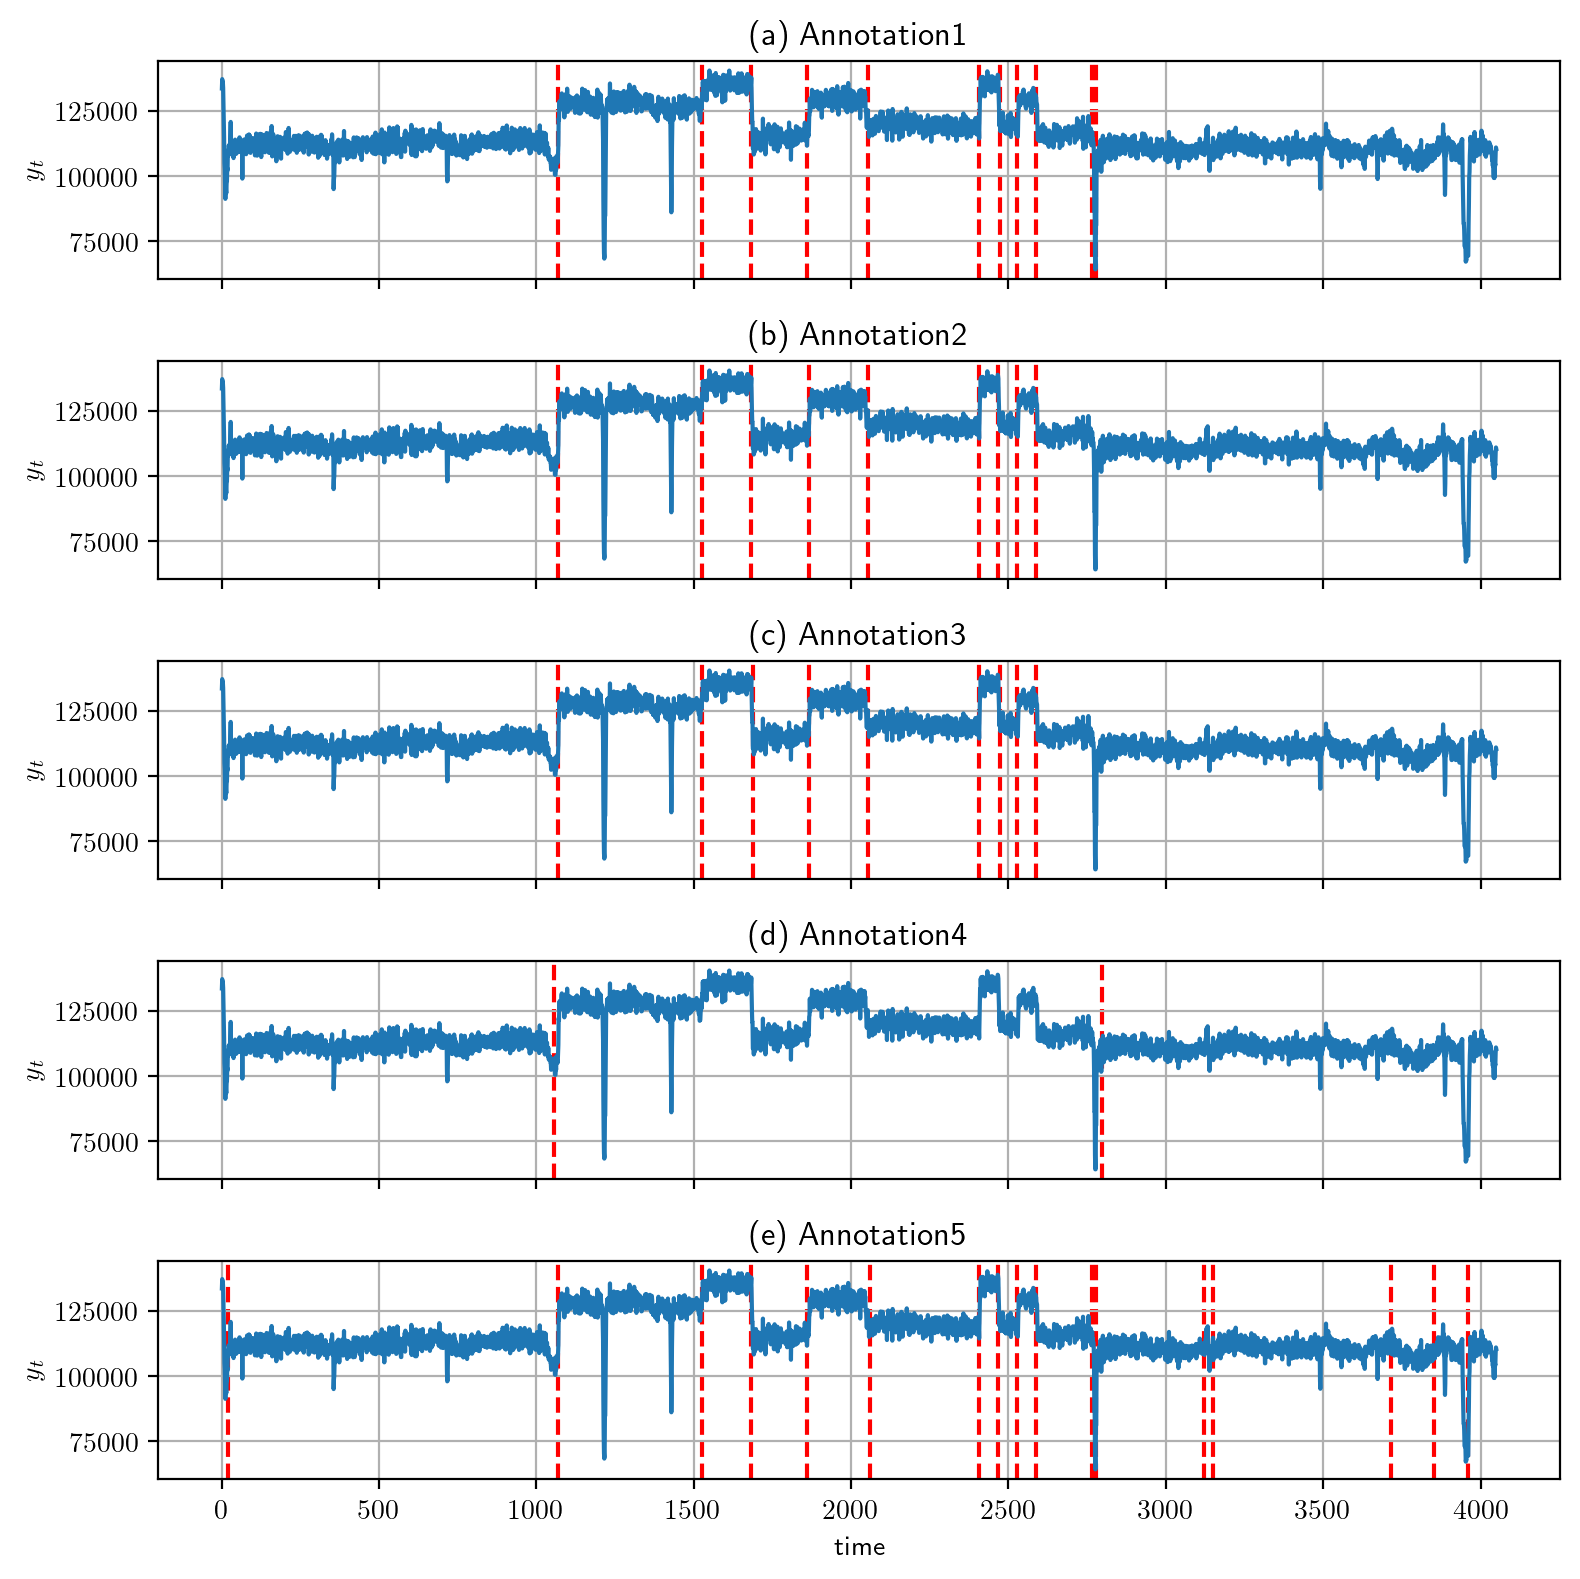

In [14]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8, 8), dpi=200)

axes[0].plot(np.arange(1, len(X)+1), X)
axes[0].set_ylabel(r'$y_{t}$')
axes[0].set_title('(a) Annotation1')
axes[0].grid()

axes[1].plot(np.arange(1, len(X)+1), X)
axes[1].set_ylabel(r'$y_{t}$')
axes[1].set_title('(b) Annotation2')
axes[1].grid()

axes[2].plot(np.arange(1, len(X)+1), X)
axes[2].set_ylabel(r'$y_{t}$')
axes[2].set_title('(c) Annotation3')
axes[2].grid()

axes[3].plot(np.arange(1, len(X)+1), X)
axes[3].set_ylabel(r'$y_{t}$')
axes[3].set_title('(d) Annotation4')
axes[3].grid()

axes[4].plot(np.arange(1, len(X)+1), X)
axes[4].set_ylabel(r'$y_{t}$')
axes[4].set_title('(e) Annotation5')
axes[4].set_xlabel('time')
axes[4].grid()

for cp in annot1:
    axes[0].axvline(x=cp, linestyle='dashed', color='red', zorder=0)
for cp in annot2:
    axes[1].axvline(x=cp, linestyle='dashed', color='red', zorder=0)
for cp in annot3:
    axes[2].axvline(x=cp, linestyle='dashed', color='red', zorder=0)
for cp in annot4:
    axes[3].axvline(x=cp, linestyle='dashed', color='red', zorder=0)
for cp in annot5:
    axes[4].axvline(x=cp, linestyle='dashed', color='red', zorder=0)

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'plot_annotations.png'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'plot_annotations.eps'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'plot_annotations.pdf'), bbox_inches='tight')

## SDEM

In [15]:
class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.pi_list = []
        self.pi_bar_list = []
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_)
        self.covariances_bar = np.copy(self.covariances_)
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[self.t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[self.t]/self.weights_.shape[0] # \overline{\gamma}_i^{(t)} in the paper
        gamma = gamma.ravel()
        self.weights_ = (1-self.r[self.t])*self.weights_ + self.r[self.t]*gamma
        
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            # E-step
            m = (1-self.r[self.t])*m + self.r[self.t]*gamma[i]*x
            cov = (1-self.r[self.t])*cov + self.r[self.t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step
            m = m/w
            cov = cov/w - np.outer(m, m)
            means.append(m)
            covariances.append(cov)

        self.means_ = np.vstack(means) # \mu_i^{(t)} in the paper
        self.covariances_ = np.stack(covariances)
        self.means_bar = np.stack(means_bar)
        self.covariances_bar = np.stack(covariances_bar)
        
        self.pi_list.append(self.weights_)
        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [16]:
def calc_scores_sdem(X, r, n_cluster, alpha=1.0, start=20, end=40, seed=0):
    np.random.seed(seed)
    rho_const = np.repeat([r], X.shape[0])
    sdem = SDEM(rho_const, alpha, n_components=n_cluster)

    X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    
    sdem.fit(X_init)

    for t in tqdm.tqdm(range(X.shape[0])):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_bar_list)
    sigma_est = np.array(sdem.covariances_list)
    
    scores = [np.nan] * start

    for t in range(start, pi_est.shape[0]):
        p = np.zeros(n_cluster)
        for k in range(n_cluster):
            p_k = pi_est[t-1, k] * norm(mu_est[t-1, k, :], np.sqrt(sigma_est[t-1, k, :, :])).pdf(X[t, :])
            p[k] = p_k
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            scores.append(-np.log(p_tot))
        else:
            scores.append(-np.log(1e-30))
    scores = np.array(scores)
    
    return scores

## SDEM

In [17]:
r_list = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1]
k_list = [1]

res_train_annot1 = []
res_test_annot1 = []

res_train_annot2 = []
res_test_annot2 = []

res_train_annot3 = []
res_test_annot3 = []

res_train_annot4 = []
res_test_annot4 = []

res_train_annot5 = []
res_test_annot5 = []

for i, r in enumerate(r_list):
    for j, k in enumerate(k_list):
        print('r =', r, 'k =', k)
        for trial in range(10):
            seed = i*len(r_list) + j*len(k_list) + trial
            scores_sdem = calc_scores_sdem(X, r, k, start=0, alpha=1.0, seed=seed)

            print('annot1:')
            auc_train = calc_auc_main(scores_sdem, annot1-1, start=0, end=1550, T=100, N_thr=100)
            res_train_annot1.append([r, k, auc_train])
            print('  train:', auc_train)
            auc_test = calc_auc_main(scores_sdem, annot1-1, start=1550, end=None, T=100, N_thr=100)
            res_test_annot1.append([r, k, auc_test])
            print('  test:', auc_test)

            print('annot2:')
            auc_train = calc_auc_main(scores_sdem, annot2-1, start=0, end=1550, T=100, N_thr=100)
            res_train_annot2.append([r, k, auc_train])
            print('  train:', auc_train)
            auc_test = calc_auc_main(scores_sdem, annot2-1, start=1550, end=None, T=100, N_thr=100)
            res_test_annot2.append([r, k, auc_test])
            print('  test:', auc_test)

            print('annot3:')
            auc_train = calc_auc_main(scores_sdem, annot3-1, start=0, end=1550, T=100, N_thr=100)
            res_train_annot3.append([r, k, auc_train])
            print('  train:', auc_train)
            auc_test = calc_auc_main(scores_sdem, annot3-1, start=1550, end=None, T=100, N_thr=100)
            res_test_annot3.append([r, k, auc_test])
            print('  test:', auc_test)

            print('annot4:')
            auc_train = calc_auc_main(scores_sdem, annot4-1, start=0, end=1550, T=100, N_thr=100)
            res_train_annot4.append([r, k, auc_train])
            print('  train:', auc_train)
            auc_test = calc_auc_main(scores_sdem, annot4-1, start=1550, end=None, T=100, N_thr=100)
            res_test_annot4.append([r, k, auc_test])
            print('  test:', auc_test)

            print('annot5:')
            auc_train = calc_auc_main(scores_sdem, annot5-1, start=0, end=1550, T=100, N_thr=100)
            res_train_annot5.append([r, k, auc_train])
            print('  train:', auc_train)
            auc_test = calc_auc_main(scores_sdem, annot5-1, start=1550, end=None, T=100, N_thr=100)
            res_test_annot5.append([r, k, auc_test])
            print('  test:', auc_test)     

  9%|▉         | 369/4050 [00:00<00:00, 3683.92it/s]

r = 0.001 k = 1


100%|██████████| 4050/4050 [00:00<00:00, 4304.03it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5
  test: 0.5
annot2:
  train: 0.5
  test: 0.5
annot3:
  train: 0.5
  test: 0.5
annot4:
  train: 0.5
  test: 0.5
annot5:
  train: 0.5
  test: 0.5


100%|██████████| 4050/4050 [00:00<00:00, 4527.55it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5
  test: 0.5
annot2:
  train: 0.5
  test: 0.5
annot3:
  train: 0.5
  test: 0.5
annot4:
  train: 0.5
  test: 0.5
annot5:
  train: 0.5
  test: 0.5


100%|██████████| 4050/4050 [00:00<00:00, 4221.51it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5
  test: 0.5
annot2:
  train: 0.5
  test: 0.5
annot3:
  train: 0.5
  test: 0.5
annot4:
  train: 0.5
  test: 0.5
annot5:
  train: 0.5
  test: 0.5


100%|██████████| 4050/4050 [00:00<00:00, 4505.85it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5
  test: 0.5
annot2:
  train: 0.5
  test: 0.5
annot3:
  train: 0.5
  test: 0.5
annot4:
  train: 0.5
  test: 0.5
annot5:
  train: 0.5
  test: 0.5


100%|██████████| 4050/4050 [00:00<00:00, 4354.49it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5
  test: 0.5
annot2:
  train: 0.5
  test: 0.5
annot3:
  train: 0.5
  test: 0.5
annot4:
  train: 0.5
  test: 0.5
annot5:
  train: 0.5
  test: 0.5


100%|██████████| 4050/4050 [00:00<00:00, 4143.74it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5
  test: 0.5
annot2:
  train: 0.5
  test: 0.5
annot3:
  train: 0.5
  test: 0.5
annot4:
  train: 0.5
  test: 0.5
annot5:
  train: 0.5
  test: 0.5


100%|██████████| 4050/4050 [00:00<00:00, 4128.49it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5
  test: 0.5
annot2:
  train: 0.5
  test: 0.5
annot3:
  train: 0.5
  test: 0.5
annot4:
  train: 0.5
  test: 0.5
annot5:
  train: 0.5
  test: 0.5


100%|██████████| 4050/4050 [00:00<00:00, 4466.92it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5
  test: 0.5
annot2:
  train: 0.5
  test: 0.5
annot3:
  train: 0.5
  test: 0.5
annot4:
  train: 0.5
  test: 0.5
annot5:
  train: 0.5
  test: 0.5


100%|██████████| 4050/4050 [00:00<00:00, 4234.75it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5
  test: 0.5
annot2:
  train: 0.5
  test: 0.5
annot3:
  train: 0.5
  test: 0.5
annot4:
  train: 0.5
  test: 0.5
annot5:
  train: 0.5
  test: 0.5


100%|██████████| 4050/4050 [00:00<00:00, 4336.41it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5
  test: 0.5
annot2:
  train: 0.5
  test: 0.5
annot3:
  train: 0.5
  test: 0.5
annot4:
  train: 0.5
  test: 0.5
annot5:
  train: 0.5
  test: 0.5
r = 0.003 k = 1


100%|██████████| 4050/4050 [00:00<00:00, 4296.02it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5004078303425774
  test: 0.787681314537368
annot2:
  train: 0.5004078303425774
  test: 0.7562058821986829
annot3:
  train: 0.5004078303425774
  test: 0.7560661728721875
annot4:
  train: 0.5003700962250185
  test: 0.6895512385919165
annot5:
  train: 0.4982848058902276
  test: 0.6792211428035695


100%|██████████| 4050/4050 [00:00<00:00, 4242.33it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5004078303425774
  test: 0.7871170646145801
annot2:
  train: 0.5004078303425774
  test: 0.7577116872990591
annot3:
  train: 0.5004078303425774
  test: 0.7575253825804215
annot4:
  train: 0.5003700962250185
  test: 0.683714406779661
annot5:
  train: 0.4982848058902276
  test: 0.6645879327419077


100%|██████████| 4050/4050 [00:00<00:00, 4128.08it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5004078303425774
  test: 0.7933972666522638
annot2:
  train: 0.5004078303425774
  test: 0.7599858810448308
annot3:
  train: 0.5004078303425774
  test: 0.7583199168223923
annot4:
  train: 0.5003700962250185
  test: 0.6914491525423729
annot5:
  train: 0.4982848058902276
  test: 0.7274186923829677


100%|██████████| 4050/4050 [00:00<00:00, 4263.41it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5004078303425774
  test: 0.7814684795166579
annot2:
  train: 0.5004078303425774
  test: 0.7498259186674056
annot3:
  train: 0.5004078303425774
  test: 0.7494939576065887
annot4:
  train: 0.5003700962250185
  test: 0.6911377009995654
annot5:
  train: 0.4982848058902276
  test: 0.6508746483179843


100%|██████████| 4050/4050 [00:00<00:00, 4451.88it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5004078303425774
  test: 0.7910433220876752
annot2:
  train: 0.5004078303425774
  test: 0.7593624232294925
annot3:
  train: 0.5004078303425774
  test: 0.7577878936176511
annot4:
  train: 0.5003700962250185
  test: 0.6850212516297263
annot5:
  train: 0.4982848058902276
  test: 0.7313296569689187


100%|██████████| 4050/4050 [00:00<00:00, 4276.13it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5004078303425774
  test: 0.7854591798847871
annot2:
  train: 0.5004078303425774
  test: 0.7549768827458885
annot3:
  train: 0.5004078303425774
  test: 0.7547862129980685
annot4:
  train: 0.5003700962250185
  test: 0.6866261190786616
annot5:
  train: 0.4982848058902276
  test: 0.6651312556376349


100%|██████████| 4050/4050 [00:00<00:00, 4274.52it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5004078303425774
  test: 0.7824624895551752
annot2:
  train: 0.5004078303425774
  test: 0.7510684566527447
annot3:
  train: 0.5004078303425774
  test: 0.7507624370203048
annot4:
  train: 0.5003700962250185
  test: 0.6907300304215558
annot5:
  train: 0.4982848058902276
  test: 0.651928063729067


100%|██████████| 4050/4050 [00:00<00:00, 4430.75it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5004078303425774
  test: 0.7807031714577712
annot2:
  train: 0.5004078303425774
  test: 0.7487271436738305
annot3:
  train: 0.5004078303425774
  test: 0.7483809520492237
annot4:
  train: 0.5003700962250185
  test: 0.6932235332464146
annot5:
  train: 0.4982848058902276
  test: 0.6475903172914133


100%|██████████| 4050/4050 [00:00<00:00, 4192.97it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5004078303425774
  test: 0.7829135832196853
annot2:
  train: 0.5004078303425774
  test: 0.7555185289433337
annot3:
  train: 0.5004078303425774
  test: 0.7543468067357143
annot4:
  train: 0.5003700962250185
  test: 0.6717835723598434
annot5:
  train: 0.4982848058902276
  test: 0.7238202086699883


100%|██████████| 4050/4050 [00:00<00:00, 4124.04it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5004078303425774
  test: 0.7821929818829193
annot2:
  train: 0.5004078303425774
  test: 0.754717433832695
annot3:
  train: 0.5004078303425774
  test: 0.753528587077864
annot4:
  train: 0.5003700962250185
  test: 0.6714793350717079
annot5:
  train: 0.4982848058902276
  test: 0.7237532867193315
r = 0.005 k = 1


100%|██████████| 4050/4050 [00:00<00:00, 4149.19it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.34053248791898805
  test: 0.8009794488353578
annot2:
  train: 0.34053248791898805
  test: 0.7700886892763423
annot3:
  train: 0.34053248791898805
  test: 0.7701553798113179
annot4:
  train: 0.608389674315322
  test: 0.7013552803129074
annot5:
  train: 0.4235080363572219
  test: 0.7360354906062534


100%|██████████| 4050/4050 [00:00<00:00, 4347.61it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.3304812279659151
  test: 0.8009762804865289
annot2:
  train: 0.3304812279659151
  test: 0.770083570368376
annot3:
  train: 0.3304812279659151
  test: 0.770150280480605
annot4:
  train: 0.595741228719467
  test: 0.7014833116036506
annot5:
  train: 0.4164429227137189
  test: 0.7360333905450404


100%|██████████| 4050/4050 [00:00<00:00, 4100.59it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.3305424321131176
  test: 0.8009762804865289
annot2:
  train: 0.3305424321131176
  test: 0.770083570368376
annot3:
  train: 0.3305424321131176
  test: 0.770150280480605
annot4:
  train: 0.5958463730569948
  test: 0.7014833116036506
annot5:
  train: 0.41649172275745583
  test: 0.7360333905450404


100%|██████████| 4050/4050 [00:00<00:00, 4212.30it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.33630300906579036
  test: 0.8009794488353578
annot2:
  train: 0.33630300906579036
  test: 0.7700886892763423
annot3:
  train: 0.33630300906579036
  test: 0.7701553798113179
annot4:
  train: 0.6031667653589934
  test: 0.7013552803129074
annot5:
  train: 0.4205272126411784
  test: 0.7360354906062534


100%|██████████| 4050/4050 [00:00<00:00, 4205.93it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.34314788200503366
  test: 0.8009794488353578
annot2:
  train: 0.34314788200503366
  test: 0.7700886892763423
annot3:
  train: 0.34314788200503366
  test: 0.7701553798113179
annot4:
  train: 0.6116124352331607
  test: 0.7013552803129074
annot5:
  train: 0.42534080364780424
  test: 0.7360354906062534


100%|██████████| 4050/4050 [00:01<00:00, 4018.97it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.33486230842628395
  test: 0.8009762804865289
annot2:
  train: 0.33486230842628395
  test: 0.770083570368376
annot3:
  train: 0.33486230842628395
  test: 0.770150280480605
annot4:
  train: 0.6013585862324204
  test: 0.7014833116036506
annot5:
  train: 0.41951572082554045
  test: 0.7360333905450404


100%|██████████| 4050/4050 [00:00<00:00, 4200.40it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.34053248791898805
  test: 0.8009794488353578
annot2:
  train: 0.34053248791898805
  test: 0.7700886892763423
annot3:
  train: 0.34053248791898805
  test: 0.7701553798113179
annot4:
  train: 0.608389674315322
  test: 0.7013552803129074
annot5:
  train: 0.4235080363572219
  test: 0.7360354906062534


100%|██████████| 4050/4050 [00:00<00:00, 4265.69it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.33486036694076343
  test: 0.8009762804865289
annot2:
  train: 0.33486036694076343
  test: 0.770083570368376
annot3:
  train: 0.33486036694076343
  test: 0.770150280480605
annot4:
  train: 0.6013545891931903
  test: 0.7014833116036506
annot5:
  train: 0.4195146070140973
  test: 0.7360333905450404


100%|██████████| 4050/4050 [00:01<00:00, 4035.04it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.33630483216804746
  test: 0.8009794488353578
annot2:
  train: 0.33630483216804746
  test: 0.7700886892763423
annot3:
  train: 0.33630483216804746
  test: 0.7701553798113179
annot4:
  train: 0.603170281273131
  test: 0.7013552803129074
annot5:
  train: 0.4205282886963015
  test: 0.7360354906062534


100%|██████████| 4050/4050 [00:01<00:00, 3949.51it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.3392196175273524
  test: 0.8009794488353578
annot2:
  train: 0.3392196175273524
  test: 0.7700886892763423
annot3:
  train: 0.3392196175273524
  test: 0.7701553798113179
annot4:
  train: 0.6067780532938565
  test: 0.7013552803129074
annot5:
  train: 0.42258714083167814
  test: 0.7360354906062534
r = 0.01 k = 1


100%|██████████| 4050/4050 [00:00<00:00, 4281.65it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.28628056359904064
  test: 0.7869341320740731
annot2:
  train: 0.28628056359904064
  test: 0.7691862299977098
annot3:
  train: 0.28628056359904064
  test: 0.7708192332543239
annot4:
  train: 0.32324537379718726
  test: 0.6544883963494131
annot5:
  train: 0.43103496643010064
  test: 0.7476920162557585


100%|██████████| 4050/4050 [00:01<00:00, 4036.48it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.284883806826926
  test: 0.7861825997318653
annot2:
  train: 0.284883806826926
  test: 0.7673483112673668
annot3:
  train: 0.284883806826926
  test: 0.7694349739547505
annot4:
  train: 0.3223602886750555
  test: 0.6580813993915688
annot5:
  train: 0.429921287134096
  test: 0.7547186645995696


100%|██████████| 4050/4050 [00:00<00:00, 4457.31it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.2844132333547213
  test: 0.7889343568948254
annot2:
  train: 0.2844132333547213
  test: 0.7706442096724283
annot3:
  train: 0.2844132333547213
  test: 0.7725290346625612
annot4:
  train: 0.32289193190229454
  test: 0.658536614515428
annot5:
  train: 0.4295460837030432
  test: 0.7583641073283803


100%|██████████| 4050/4050 [00:00<00:00, 4337.21it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.2818320757084647
  test: 0.7979953394908873
annot2:
  train: 0.2818320757084647
  test: 0.7709983374038674
annot3:
  train: 0.2818320757084647
  test: 0.7729305999898988
annot4:
  train: 0.32096347150259064
  test: 0.686551955671447
annot5:
  train: 0.42748462638157925
  test: 0.758047953407169


100%|██████████| 4050/4050 [00:00<00:00, 4497.12it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.28503950449501253
  test: 0.7860975889723506
annot2:
  train: 0.28503950449501253
  test: 0.7684771143904602
annot3:
  train: 0.28503950449501253
  test: 0.7700396695884485
annot4:
  train: 0.32185355292376017
  test: 0.6563275097783571
annot5:
  train: 0.4300454299146042
  test: 0.7521498697237321


100%|██████████| 4050/4050 [00:00<00:00, 4495.70it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.28376906266499674
  test: 0.7919423674707741
annot2:
  train: 0.28376906266499674
  test: 0.773447084512681
annot3:
  train: 0.28376906266499674
  test: 0.7752698622240257
annot4:
  train: 0.3236294596595115
  test: 0.6596494132985659
annot5:
  train: 0.4290324656024821
  test: 0.7628094757265537


100%|██████████| 4050/4050 [00:00<00:00, 4595.03it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.2822657372791264
  test: 0.8026690962621603
annot2:
  train: 0.2822657372791264
  test: 0.7721695813089928
annot3:
  train: 0.2822657372791264
  test: 0.7734767578148811
annot4:
  train: 0.3223843819393042
  test: 0.7002951542807475
annot5:
  train: 0.42783039876110945
  test: 0.7537895975189037


100%|██████████| 4050/4050 [00:00<00:00, 4312.64it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.2837538859306227
  test: 0.7917735340825555
annot2:
  train: 0.2837538859306227
  test: 0.7712964438624678
annot3:
  train: 0.2837538859306227
  test: 0.7729554487776757
annot4:
  train: 0.32345621761658033
  test: 0.6673805519339416
annot5:
  train: 0.4290169477549186
  test: 0.7614144585936777


100%|██████████| 4050/4050 [00:00<00:00, 4377.75it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.282910973418222
  test: 0.7954985353977503
annot2:
  train: 0.282910973418222
  test: 0.7721641617001488
annot3:
  train: 0.282910973418222
  test: 0.7743457269594022
annot4:
  train: 0.3232307920059215
  test: 0.6742903737505431
annot5:
  train: 0.4283448663788729
  test: 0.7631108633349999


100%|██████████| 4050/4050 [00:00<00:00, 4342.94it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.28438207487978184
  test: 0.7906961370632987
annot2:
  train: 0.28438207487978184
  test: 0.7721150075961937
annot3:
  train: 0.28438207487978184
  test: 0.774031142838732
annot4:
  train: 0.3228258327165063
  test: 0.658998370273794
annot5:
  train: 0.4295212400444135
  test: 0.758786713764259
r = 0.03 k = 1


100%|██████████| 4050/4050 [00:00<00:00, 4375.97it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5832837149615135
  test: 0.6774786240415497
annot2:
  train: 0.5832837149615135
  test: 0.6610113759337899
annot3:
  train: 0.5832837149615135
  test: 0.664647552303842
annot4:
  train: 0.5751686158401185
  test: 0.6740896566710127
annot5:
  train: 0.7256892340722698
  test: 0.6970408457458754


100%|██████████| 4050/4050 [00:00<00:00, 4496.17it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5824269516072895
  test: 0.6780728082600437
annot2:
  train: 0.5824269516072895
  test: 0.6613400979375766
annot3:
  train: 0.5824269516072895
  test: 0.6647706119719329
annot4:
  train: 0.5753376017764619
  test: 0.6739477618426771
annot5:
  train: 0.7250045609634688
  test: 0.6995856093330082


100%|██████████| 4050/4050 [00:00<00:00, 4551.32it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5845119886730894
  test: 0.6772440012100451
annot2:
  train: 0.5845119886730894
  test: 0.6596399141953543
annot3:
  train: 0.5845119886730894
  test: 0.6634907287271004
annot4:
  train: 0.5736603256846781
  test: 0.6764551716644936
annot5:
  train: 0.7267977596305801
  test: 0.6948986185978523


100%|██████████| 4050/4050 [00:00<00:00, 4421.96it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5838229033732127
  test: 0.6779029385577293
annot2:
  train: 0.5838229033732127
  test: 0.6600063776558268
annot3:
  train: 0.5838229033732127
  test: 0.663870573134817
annot4:
  train: 0.5834596225018505
  test: 0.6774019556714472
annot5:
  train: 0.7263759649005166
  test: 0.7015443076020766


100%|██████████| 4050/4050 [00:00<00:00, 4534.07it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5822301039168286
  test: 0.6776836360129578
annot2:
  train: 0.5822301039168286
  test: 0.6611121736652465
annot3:
  train: 0.5822301039168286
  test: 0.6644440109858532
annot4:
  train: 0.5752688378978534
  test: 0.6740573229030855
annot5:
  train: 0.7248429639134156
  test: 0.6996477464383127


100%|██████████| 4050/4050 [00:00<00:00, 4439.79it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.582431805321091
  test: 0.6784094387223844
annot2:
  train: 0.582431805321091
  test: 0.6597484811983281
annot3:
  train: 0.582431805321091
  test: 0.6636775439616992
annot4:
  train: 0.574150666173205
  test: 0.6800998913515862
annot5:
  train: 0.7251407102537708
  test: 0.6976211379544869


100%|██████████| 4050/4050 [00:00<00:00, 4586.26it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5798708912128839
  test: 0.6775123009493098
annot2:
  train: 0.5798708912128839
  test: 0.657207509829597
annot3:
  train: 0.5798708912128839
  test: 0.6614621982504137
annot4:
  train: 0.5773319763138416
  test: 0.6848262929161234
annot5:
  train: 0.7232248979371155
  test: 0.6991676395028662


100%|██████████| 4050/4050 [00:00<00:00, 4559.30it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5812646884034123
  test: 0.6776501109219122
annot2:
  train: 0.5812646884034123
  test: 0.6595349556029141
annot3:
  train: 0.5812646884034123
  test: 0.6634955563721604
annot4:
  train: 0.5742515173945225
  test: 0.6782686875271621
annot5:
  train: 0.7242101302321198
  test: 0.6960450626029069


100%|██████████| 4050/4050 [00:00<00:00, 4621.92it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5795151731828762
  test: 0.679920021634542
annot2:
  train: 0.5795151731828762
  test: 0.6592505205446881
annot3:
  train: 0.5795151731828762
  test: 0.6635428157431386
annot4:
  train: 0.5793245743893413
  test: 0.6851558452846588
annot5:
  train: 0.7229412724604797
  test: 0.7016322219293301


100%|██████████| 4050/4050 [00:00<00:00, 4385.90it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5825816785326158
  test: 0.6760691642628471
annot2:
  train: 0.5825816785326158
  test: 0.6550654076857046
annot3:
  train: 0.5825816785326158
  test: 0.6581203323621153
annot4:
  train: 0.5709962990377497
  test: 0.6820633202955236
annot5:
  train: 0.7251217377029177
  test: 0.7052444425133031
r = 0.05 k = 1


100%|██████████| 4050/4050 [00:00<00:00, 4642.69it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.6166327774844504
  test: 0.6260327249509516
annot2:
  train: 0.6166327774844504
  test: 0.5998206074507384
annot3:
  train: 0.6166327774844504
  test: 0.601901123838152
annot4:
  train: 0.6175766099185789
  test: 0.6825181877444589
annot5:
  train: 0.7665938271739183
  test: 0.6669838884621418


100%|██████████| 4050/4050 [00:00<00:00, 4353.43it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.6170561633878449
  test: 0.6271385711024012
annot2:
  train: 0.6170561633878449
  test: 0.6030603307360003
annot3:
  train: 0.6170561633878449
  test: 0.6054313584456793
annot4:
  train: 0.6153862694300518
  test: 0.6765334202520644
annot5:
  train: 0.7669345024502342
  test: 0.6812179963024427


100%|██████████| 4050/4050 [00:00<00:00, 4449.80it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.6163545057853902
  test: 0.6268554659330883
annot2:
  train: 0.6163545057853902
  test: 0.6016477289216551
annot3:
  train: 0.6163545057853902
  test: 0.6034540859954753
annot4:
  train: 0.6172350111028867
  test: 0.6816063233376792
annot5:
  train: 0.765864507216592
  test: 0.6723350338503512


100%|██████████| 4050/4050 [00:00<00:00, 4098.00it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


annot1:
  train: 0.6116986340939063
  test: 0.6339233656947162
annot2:
  train: 0.6116986340939063
  test: 0.6136677569987256
annot3:
  train: 0.6116986340939063
  test: 0.6158836767428373
annot4:
  train: 0.6210886380458919
  test: 0.6668286179921774
annot5:
  train: 0.7626596752533601


 12%|█▏        | 479/4050 [00:00<00:00, 4780.92it/s]

  test: 0.670254960278701


100%|██████████| 4050/4050 [00:00<00:00, 4549.86it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.6128441579043321
  test: 0.6303699436700582
annot2:
  train: 0.6128441579043321
  test: 0.605971982370537
annot3:
  train: 0.6128441579043321
  test: 0.6086125257535359
annot4:
  train: 0.6166837527757216
  test: 0.6764868970013037
annot5:
  train: 0.7630624974325702
  test: 0.6672813477207895


100%|██████████| 4050/4050 [00:00<00:00, 4381.92it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.6079358694185251
  test: 0.6318546121290861
annot2:
  train: 0.6079358694185251
  test: 0.6107717697820094
annot3:
  train: 0.6079358694185251
  test: 0.6131644586402132
annot4:
  train: 0.6198309400444115
  test: 0.6686417427205563
annot5:
  train: 0.7596595014232621
  test: 0.6670461243938564


100%|██████████| 4050/4050 [00:00<00:00, 4498.63it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.6132745994502281
  test: 0.6288689516138347
annot2:
  train: 0.6132745994502281
  test: 0.6105072089538932
annot3:
  train: 0.6132745994502281
  test: 0.6137436576203471
annot4:
  train: 0.6138012953367876
  test: 0.6593335940895263
annot5:
  train: 0.7640469746011723
  test: 0.6738569440937021


100%|██████████| 4050/4050 [00:00<00:00, 4225.17it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.6204455946036173
  test: 0.6232858193221359
annot2:
  train: 0.6204455946036173
  test: 0.5970809077669987
annot3:
  train: 0.6204455946036173
  test: 0.5994797568065092
annot4:
  train: 0.6203275721687639
  test: 0.681976162538027
annot5:
  train: 0.7696370054526168
  test: 0.6766563503973382


100%|██████████| 4050/4050 [00:00<00:00, 4361.28it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.6174586664835671
  test: 0.6256765959418601
annot2:
  train: 0.6174586664835671
  test: 0.6040619303947398
annot3:
  train: 0.6174586664835671
  test: 0.6064235126516693
annot4:
  train: 0.6161289785344191
  test: 0.6696136245110822
annot5:
  train: 0.767379970393004
  test: 0.678802357655545


100%|██████████| 4050/4050 [00:00<00:00, 4385.02it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.6123772306366415
  test: 0.632791103434906
annot2:
  train: 0.6123772306366415
  test: 0.6119502305082021
annot3:
  train: 0.6123772306366415
  test: 0.6143295442473174
annot4:
  train: 0.6206150999259806
  test: 0.6685262494567579
annot5:
  train: 0.7631976461803894
  test: 0.6700070624646819
r = 0.1 k = 1


100%|██████████| 4050/4050 [00:00<00:00, 4501.39it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5877359674398672
  test: 0.5714374805237308
annot2:
  train: 0.5877359674398672
  test: 0.5482822392425135
annot3:
  train: 0.5877359674398672
  test: 0.5490516603302372
annot4:
  train: 0.6031954108068098
  test: 0.6285639504563233
annot5:
  train: 0.6947815328703502
  test: 0.6230277130995526


100%|██████████| 4050/4050 [00:00<00:00, 4324.06it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5875430027204473
  test: 0.5714374805237308
annot2:
  train: 0.5875430027204473
  test: 0.5482822392425135
annot3:
  train: 0.5875430027204473
  test: 0.5490516603302372
annot4:
  train: 0.6030264248704663
  test: 0.6285639504563233
annot5:
  train: 0.6952045924371373
  test: 0.6230277130995526


100%|██████████| 4050/4050 [00:00<00:00, 4488.91it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5879572967892092
  test: 0.5714374805237308
annot2:
  train: 0.5879572967892092
  test: 0.5482822392425135
annot3:
  train: 0.5879572967892092
  test: 0.5490516603302372
annot4:
  train: 0.6033822353811992
  test: 0.6285639504563233
annot5:
  train: 0.693797017945428
  test: 0.6230277130995526


100%|██████████| 4050/4050 [00:00<00:00, 4443.10it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5879289321592871
  test: 0.5714374805237308
annot2:
  train: 0.5879289321592871
  test: 0.5482822392425135
annot3:
  train: 0.5879289321592871
  test: 0.5490516603302372
annot4:
  train: 0.6033643967431532
  test: 0.6285639504563233
annot5:
  train: 0.6942738613902059
  test: 0.6230277130995526


100%|██████████| 4050/4050 [00:00<00:00, 4523.77it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5879572967892092
  test: 0.5714374805237308
annot2:
  train: 0.5879572967892092
  test: 0.5482822392425135
annot3:
  train: 0.5879572967892092
  test: 0.5490516603302372
annot4:
  train: 0.6033822353811992
  test: 0.6285639504563233
annot5:
  train: 0.693797017945428
  test: 0.6230277130995526


100%|██████████| 4050/4050 [00:00<00:00, 4359.89it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5875430027204473
  test: 0.5714374805237308
annot2:
  train: 0.5875430027204473
  test: 0.5482822392425135
annot3:
  train: 0.5875430027204473
  test: 0.5490516603302372
annot4:
  train: 0.6030264248704663
  test: 0.6285639504563233
annot5:
  train: 0.6952045924371373
  test: 0.6230277130995526


100%|██████████| 4050/4050 [00:00<00:00, 4586.24it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5875430027204473
  test: 0.5714374805237308
annot2:
  train: 0.5875430027204473
  test: 0.5482822392425135
annot3:
  train: 0.5875430027204473
  test: 0.5490516603302372
annot4:
  train: 0.6030264248704663
  test: 0.6285639504563233
annot5:
  train: 0.6952045924371373
  test: 0.6230277130995526


100%|██████████| 4050/4050 [00:00<00:00, 4523.47it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5879572967892092
  test: 0.5714374805237308
annot2:
  train: 0.5879572967892092
  test: 0.5482822392425135
annot3:
  train: 0.5879572967892092
  test: 0.5490516603302372
annot4:
  train: 0.6033822353811992
  test: 0.6285639504563233
annot5:
  train: 0.693797017945428
  test: 0.6230277130995526


100%|██████████| 4050/4050 [00:00<00:00, 4579.38it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
  0%|          | 0/4050 [00:00<?, ?it/s]

annot1:
  train: 0.5879572967892092
  test: 0.5714374805237308
annot2:
  train: 0.5879572967892092
  test: 0.5482822392425135
annot3:
  train: 0.5879572967892092
  test: 0.5490516603302372
annot4:
  train: 0.6033822353811992
  test: 0.6285639504563233
annot5:
  train: 0.693797017945428
  test: 0.6230277130995526


100%|██████████| 4050/4050 [00:00<00:00, 4457.44it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


annot1:
  train: 0.5873500380010277
  test: 0.5714374805237308
annot2:
  train: 0.5873500380010277
  test: 0.5482822392425135
annot3:
  train: 0.5873500380010277
  test: 0.5490516603302372
annot4:
  train: 0.6028574389341229
  test: 0.6285639504563233
annot5:
  train: 0.6959378956862347
  test: 0.6230277130995526


In [19]:
res_train_annot1_df = pd.DataFrame(res_train_annot1, columns=['r', 'k', 'AUC'])
res_test_annot1_df = pd.DataFrame(res_test_annot1, columns=['r', 'k', 'AUC'])
print(res_train_annot1_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot1_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))

             mean       std
r     k                    
0.001 1  0.500000  0.000000
0.003 1  0.500408  0.000000
0.005 1  0.336679  0.004229
0.010 1  0.283953  0.001348
0.030 1  0.582194  0.001596
0.050 1  0.614608  0.003624
0.100 1  0.587747  0.000234
             mean       std
r     k                    
0.001 1  0.500000  0.000000
0.003 1  0.785444  0.004302
0.005 1  0.800978  0.000002
0.010 1  0.791872  0.005450
0.030 1  0.677794  0.000971
0.050 1  0.628680  0.003467
0.100 1  0.571437  0.000000


In [20]:
res_train_annot2_df = pd.DataFrame(res_train_annot2, columns=['r', 'k', 'AUC'])
res_test_annot2_df = pd.DataFrame(res_test_annot2, columns=['r', 'k', 'AUC'])
print(res_train_annot2_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot2_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))

             mean       std
r     k                    
0.001 1  0.500000  0.000000
0.003 1  0.500408  0.000000
0.005 1  0.336679  0.004229
0.010 1  0.283953  0.001348
0.030 1  0.582194  0.001596
0.050 1  0.614608  0.003624
0.100 1  0.587747  0.000234
             mean       std
r     k                    
0.001 1  0.500000  0.000000
0.003 1  0.754810  0.003862
0.005 1  0.770087  0.000003
0.010 1  0.770785  0.001906
0.030 1  0.659392  0.001929
0.050 1  0.605854  0.005639
0.100 1  0.548282  0.000000


In [21]:
res_train_annot3_df = pd.DataFrame(res_train_annot3, columns=['r', 'k', 'AUC'])
res_test_annot3_df = pd.DataFrame(res_test_annot3, columns=['r', 'k', 'AUC'])
print(res_train_annot3_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot3_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))

             mean       std
r     k                    
0.001 1  0.500000  0.000000
0.003 1  0.500408  0.000000
0.005 1  0.336679  0.004229
0.010 1  0.283953  0.001348
0.030 1  0.582194  0.001596
0.050 1  0.614608  0.003624
0.100 1  0.587747  0.000234
             mean       std
r     k                    
0.001 1  0.500000  0.000000
0.003 1  0.754100  0.003542
0.005 1  0.770153  0.000003
0.010 1  0.772583  0.001914
0.030 1  0.663152  0.001997
0.050 1  0.608242  0.005785
0.100 1  0.549052  0.000000


In [22]:
res_train_annot4_df = pd.DataFrame(res_train_annot4, columns=['r', 'k', 'AUC'])
res_test_annot4_df = pd.DataFrame(res_test_annot4, columns=['r', 'k', 'AUC'])
print(res_train_annot4_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot4_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))

             mean       std
r     k                    
0.001 1  0.500000  0.000000
0.003 1  0.500370  0.000000
0.005 1  0.603581  0.005297
0.010 1  0.322684  0.000817
0.030 1  0.575895  0.003448
0.050 1  0.617867  0.002482
0.100 1  0.603203  0.000202
             mean       std
r     k                    
0.001 1  0.500000  0.000000
0.003 1  0.685472  0.007888
0.005 1  0.701406  0.000066
0.010 1  0.667460  0.015209
0.030 1  0.678637  0.004278
0.050 1  0.673206  0.007780
0.100 1  0.628564  0.000000


In [23]:
res_train_annot5_df = pd.DataFrame(res_train_annot5, columns=['r', 'k', 'AUC'])
res_test_annot5_df = pd.DataFrame(res_test_annot5, columns=['r', 'k', 'AUC'])
print(res_train_annot5_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot5_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))

             mean       std
r     k                    
0.001 1  0.500000  0.000000
0.003 1  0.498285  0.000000
0.005 1  0.420796  0.002972
0.010 1  0.429178  0.001077
0.030 1  0.724935  0.001231
0.050 1  0.764904  0.002906
0.100 1  0.694580  0.000789
             mean       std
r     k                    
0.001 1  0.500000  0.000000
0.003 1  0.686566  0.035641
0.005 1  0.736035  0.000001
0.010 1  0.757088  0.004970
0.030 1  0.699243  0.003053
0.050 1  0.672444  0.005094
0.100 1  0.623028  0.000000


## IEM

In [24]:
alpha = 1.0
k = 3
rhos = 1.0 / np.arange(1, X.shape[0]+1)
start = 20
end = 50

sdem = SDEM(rhos, alpha, n_components=k)
sdem.fit(X[start:end])

for t in tqdm.tqdm(range(start, len(X))):
    sdem.update(X[t, :])
    
pi_est = np.array(sdem.pi_list)
mu_est = np.array(sdem.means_list)
sigma_est = np.array(sdem.covariances_list)

100%|██████████| 4030/4030 [00:02<00:00, 1915.85it/s]


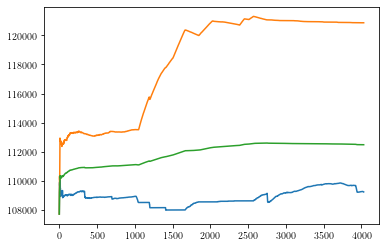

In [25]:
plt.plot(mu_est[:, 0, 0], label='mu0')
plt.plot(mu_est[:, 1, 0], label='mu1')
plt.plot(mu_est[:, 2, 0], label='mu2')
plt.show()

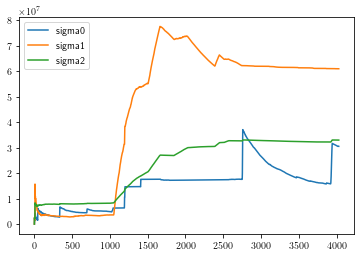

In [26]:
plt.plot(sigma_est[:, 0, 0, 0], label='sigma0')
plt.plot(sigma_est[:, 1, 0, 0], label='sigma1')
plt.plot(sigma_est[:, 2, 0, 0], label='sigma2')
plt.legend(loc='best')
plt.show()

In [27]:
def calc_scores_iem(X, k, alpha=1.0, start=20, end=40, seed=0):
    np.random.seed(seed)
    rhos = 1.0 / np.arange(1, X.shape[0]+1)
    sdem = SDEM(rhos, alpha, n_components=k)

    xmin = np.min(X[start:end, :])
    xmax = np.max(X[start:end, :])
    
    X_init = np.random.uniform(xmin, xmax, 20).reshape(20, X.shape[1])
    sdem.fit(X_init)
    
    for t in tqdm.tqdm(range(X.shape[0])):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    scores = [np.nan] * start

    n_cluster = pi_est.shape[1]
    for t in range(start, X.shape[0]):
        p = np.zeros(n_cluster)
        for i in range(n_cluster):
            p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            scores.append(-np.log(p_tot))
        else:
            scores.append(-np.log(-1.0/np.finfo(np.float).min))
    scores = np.array(scores)
    
    return scores

In [28]:
k_list = [1]

res_train_annot1 = []
res_test_annot1 = []

res_train_annot2 = []
res_test_annot2 = []

res_train_annot3 = []
res_test_annot3 = []

res_train_annot4 = []
res_test_annot4 = []

res_train_annot5 = []
res_test_annot5 = []

for i, k in enumerate(k_list):
    print('i =', i, 'k =', k)
    for trial in range(10):
        seed = i * len(k_list) + trial
        scores_iem = calc_scores_iem(X, k, alpha=1.0, seed=seed)
        
        print('annot1:')
        auc_train = calc_auc_main(scores_iem, annot1-1, start=20, end=1550, T=100, N_thr=100)
        res_train_annot1.append([k, auc_train])
        print('  train:', auc_train)

        auc_test = calc_auc_main(scores_iem, annot1-1, start=1550, end=None, T=100, N_thr=100)
        res_test_annot1.append([k, auc_test])
        print('  test:', auc_test)     
        
        
        print('annot2:')
        auc_train = calc_auc_main(scores_iem, annot2-1, start=20, end=1550, T=100, N_thr=100)
        res_train_annot2.append([k, auc_train])
        print('  train:', auc_train)

        auc_test = calc_auc_main(scores_iem, annot2-1, start=1550, end=None, T=100, N_thr=100)
        res_test_annot2.append([k, auc_test])
        print('  test:', auc_test)

        print('annot3:')
        auc_train = calc_auc_main(scores_iem, annot3-1, start=20, end=1550, T=100, N_thr=100)
        res_train_annot3.append([k, auc_train])
        print('  train:', auc_train)

        auc_test = calc_auc_main(scores_iem, annot3-1, start=1550, end=None, T=100, N_thr=100)
        res_test_annot3.append([k, auc_test])
        print('  test:', auc_test)     

        print('annot4:')
        auc_train = calc_auc_main(scores_iem, annot4-1, start=20, end=1550, T=100, N_thr=100)
        res_train_annot4.append([k, auc_train])
        print('  train:', auc_train)

        auc_test = calc_auc_main(scores_iem, annot4-1, start=1550, end=None, T=100, N_thr=100)
        res_test_annot4.append([k, auc_test])
        print('  test:', auc_test)     

        print('annot5:')
        auc_train = calc_auc_main(scores_iem, annot5-1, start=20, end=1550, T=100, N_thr=100)
        res_train_annot5.append([k, auc_train])
        print('  train:', auc_train)

        auc_test = calc_auc_main(scores_iem, annot5-1, start=1550, end=None, T=100, N_thr=100)
        res_test_annot5.append([k, auc_test])
        print('  test:', auc_test)     

  7%|▋         | 273/4050 [00:00<00:01, 2723.28it/s]

i = 0 k = 1


100%|██████████| 4050/4050 [00:01<00:00, 2670.95it/s]


annot1:
  train: 0.8001389761401025
  test: 0.5345881116819199
annot2:
  train: 0.8001389761401025
  test: 0.5527353744862298
annot3:
  train: 0.8001389761401025
  test: 0.5459216813858754
annot4:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
  7%|▋         | 274/4050 [00:00<00:01, 2739.89it/s]

  train: 0.6824679188580015
  test: 0.5383257714037375
annot5:
  train: 0.7864931892647847
  test: 0.5784797240160496


100%|██████████| 4050/4050 [00:01<00:00, 2561.11it/s]


annot1:
  train: 0.8001389761401025
  test: 0.5345881116819199
annot2:
  train: 0.8001389761401025
  test: 0.5527353744862298
annot3:
  train: 0.8001389761401025
  test: 0.5459216813858754
annot4:
  train: 0.6824679188580015
  test: 0.5383257714037375
annot5:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
  6%|▌         | 242/4050 [00:00<00:01, 2414.46it/s]

  train: 0.7864931892647847
  test: 0.5784797240160496


100%|██████████| 4050/4050 [00:01<00:00, 2493.47it/s]


annot1:
  train: 0.8001389761401025
  test: 0.5345881116819199
annot2:
  train: 0.8001389761401025
  test: 0.5527353744862298
annot3:
  train: 0.8001389761401025
  test: 0.5459216813858754
annot4:
  train: 0.6824679188580015
  test: 0.5383257714037375
annot5:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
  6%|▋         | 254/4050 [00:00<00:01, 2532.05it/s]

  train: 0.7864931892647847
  test: 0.5784797240160496


100%|██████████| 4050/4050 [00:01<00:00, 2799.28it/s]


annot1:
  train: 0.8001389761401025
  test: 0.5345881116819199
annot2:
  train: 0.8001389761401025
  test: 0.5527353744862298
annot3:
  train: 0.8001389761401025
  test: 0.5459216813858754
annot4:
  train: 0.6824679188580015
  test: 0.5383257714037375
annot5:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
  7%|▋         | 271/4050 [00:00<00:01, 2703.38it/s]

  train: 0.7864931892647847
  test: 0.5784797240160496


100%|██████████| 4050/4050 [00:01<00:00, 2834.71it/s]


annot1:
  train: 0.8001389761401025
  test: 0.5345881116819199
annot2:
  train: 0.8001389761401025
  test: 0.5527353744862298
annot3:
  train: 0.8001389761401025
  test: 0.5459216813858754
annot4:
  train: 0.6824679188580015
  test: 0.5383257714037375
annot5:
  train: 0.7864931892647847


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
  6%|▋         | 255/4050 [00:00<00:01, 2548.09it/s]

  test: 0.5784797240160496


100%|██████████| 4050/4050 [00:01<00:00, 2796.65it/s]


annot1:
  train: 0.8001389761401025
  test: 0.5345881116819199
annot2:
  train: 0.8001389761401025
  test: 0.5527353744862298
annot3:
  train: 0.8001389761401025
  test: 0.5459216813858754
annot4:
  train: 0.6824679188580015
  test: 0.5383257714037375
annot5:
  train: 0.7864931892647847


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
  7%|▋         | 288/4050 [00:00<00:01, 2871.87it/s]

  test: 0.5784797240160496


100%|██████████| 4050/4050 [00:01<00:00, 3079.55it/s]


annot1:
  train: 0.8001389761401025
  test: 0.5345881116819199
annot2:
  train: 0.8001389761401025
  test: 0.5527353744862298
annot3:
  train: 0.8001389761401025
  test: 0.5459216813858754
annot4:
  train: 0.6824679188580015
  test: 0.5383257714037375
annot5:
  train: 0.7864931892647847


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
 14%|█▍        | 558/4050 [00:00<00:01, 2766.67it/s]

  test: 0.5784797240160496


100%|██████████| 4050/4050 [00:01<00:00, 2979.26it/s]


annot1:
  train: 0.8001389761401025
  test: 0.5345881116819199
annot2:
  train: 0.8001389761401025
  test: 0.5527353744862298
annot3:
  train: 0.8001389761401025
  test: 0.5459216813858754
annot4:
  train: 0.6824679188580015
  test: 0.5383257714037375
annot5:
  train: 0.7864931892647847


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
 13%|█▎        | 534/4050 [00:00<00:01, 2689.38it/s]

  test: 0.5784797240160496


100%|██████████| 4050/4050 [00:01<00:00, 2897.09it/s]


annot1:
  train: 0.8001389761401025
  test: 0.5345881116819199
annot2:
  train: 0.8001389761401025
  test: 0.5527353744862298
annot3:
  train: 0.8001389761401025
  test: 0.5459216813858754
annot4:
  train: 0.6824679188580015
  test: 0.5383257714037375
annot5:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
 13%|█▎        | 520/4050 [00:00<00:01, 2574.43it/s]

  train: 0.7864931892647847
  test: 0.5784797240160496


100%|██████████| 4050/4050 [00:01<00:00, 2971.63it/s]


annot1:
  train: 0.8001389761401025
  test: 0.5345881116819199
annot2:
  train: 0.8001389761401025
  test: 0.5527353744862298
annot3:
  train: 0.8001389761401025
  test: 0.5459216813858754
annot4:
  train: 0.6824679188580015
  test: 0.5383257714037375
annot5:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.7864931892647847
  test: 0.5784797240160496


In [29]:
res_train_annot1_df = pd.DataFrame(res_train_annot1, columns=['k', 'AUC'])
res_test_annot1_df = pd.DataFrame(res_test_annot1, columns=['k', 'AUC'])
print(res_train_annot1_df.groupby(['k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot1_df.groupby(['k'])['AUC'].agg(mean=np.mean, std=np.std))

       mean  std
k               
1  0.800139  0.0
       mean  std
k               
1  0.534588  0.0


In [30]:
res_train_annot2_df = pd.DataFrame(res_train_annot2, columns=['k', 'AUC'])
res_test_annot2_df = pd.DataFrame(res_test_annot2, columns=['k', 'AUC'])
print(res_train_annot2_df.groupby(['k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot2_df.groupby(['k'])['AUC'].agg(mean=np.mean, std=np.std))

       mean  std
k               
1  0.800139  0.0
       mean  std
k               
1  0.552735  0.0


In [31]:
res_train_annot3_df = pd.DataFrame(res_train_annot3, columns=['k', 'AUC'])
res_test_annot3_df = pd.DataFrame(res_test_annot3, columns=['k', 'AUC'])
print(res_train_annot3_df.groupby(['k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot3_df.groupby(['k'])['AUC'].agg(mean=np.mean, std=np.std))

       mean  std
k               
1  0.800139  0.0
       mean  std
k               
1  0.545922  0.0


In [32]:
res_train_annot4_df = pd.DataFrame(res_train_annot4, columns=['k', 'AUC'])
res_test_annot4_df = pd.DataFrame(res_test_annot4, columns=['k', 'AUC'])
print(res_train_annot4_df.groupby(['k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot4_df.groupby(['k'])['AUC'].agg(mean=np.mean, std=np.std))

       mean  std
k               
1  0.682468  0.0
       mean  std
k               
1  0.538326  0.0


In [33]:
res_train_annot5_df = pd.DataFrame(res_train_annot5, columns=['k', 'AUC'])
res_test_annot5_df = pd.DataFrame(res_test_annot5, columns=['k', 'AUC'])
print(res_train_annot5_df.groupby(['k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot5_df.groupby(['k'])['AUC'].agg(mean=np.mean, std=np.std))

       mean  std
k               
1  0.786493  0.0
      mean  std
k              
1  0.57848  0.0


## sEM

In [34]:
def sem(X, theta0, rho, start, end, seed):
    np.random.seed(seed)
    
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    theta = deepcopy(theta0)
    pi_est = np.nan * np.ones((N, K, 1))
    mu_est = np.nan * np.ones((N, K, D))
    sigma_est = np.nan * np.ones((N, K, D, D))
    
    s = SuffStatGMM(K, D)
    
    X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])
    
    # initialization
    tau = compute_tau(X_init, theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)
    
    inds = np.arange(N)
    
    for n in tqdm.tqdm(range(start, N)):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if np.any(np.isnan(tau_indiv_new)):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            continue
        
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()
        
    return pi_est, mu_est, sigma_est

In [35]:
def calc_scores_sem(X, theta0, r, k, start=20, end=40, seed=0):
    rho_const = np.repeat([r], X.shape[0])
    pi_est, mu_est, sigma_est = sem(X, theta0, rho_const, start, end, seed)
    
    plt.plot(X.ravel())
    plt.plot(mu_est.ravel(), linestyle='dashed')
    plt.show()
    
    scores = [np.nan]*start
    for t in range(start, pi_est.shape[0]):
        p = np.zeros(k)
        for i in range(k):
            p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            scores.append(-np.log(p_tot))
        else:
            scores.append(-np.log(1e-30))
            
    return scores

  0%|          | 0/4030 [00:00<?, ?it/s]

r = 0.001 , k = 1


100%|██████████| 4030/4030 [00:04<00:00, 894.82it/s]


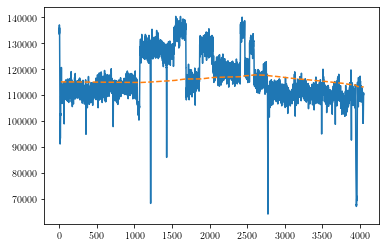

annot1:
  train: 0.8280130079529877
  test: 0.4682818908996243
annot2:
  train: 0.8280130079529877


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.4851996006972064
annot3:
  train: 0.8280130079529877
  test: 0.4747838096249867
annot4:
  train: 0.7293227239082162
  test: 0.5026539330725771
annot5:


  3%|▎         | 101/4030 [00:00<00:03, 1001.36it/s]

  train: 0.6634470342259532
  test: 0.578663722320452


100%|██████████| 4030/4030 [00:04<00:00, 1004.43it/s]


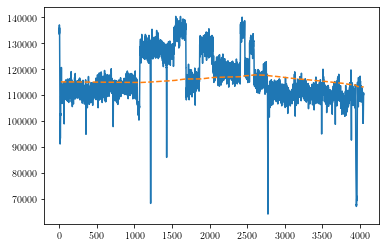

annot1:
  train: 0.8280130079529877
  test: 0.4682818908996243
annot2:
  train: 0.8280130079529877


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.4851996006972064
annot3:
  train: 0.8280130079529877
  test: 0.4747838096249867
annot4:
  train: 0.7293227239082162
  test: 0.5026539330725771
annot5:


  3%|▎         | 106/4030 [00:00<00:03, 1054.38it/s]

  train: 0.6634470342259532
  test: 0.578663722320452


100%|██████████| 4030/4030 [00:03<00:00, 1044.68it/s]


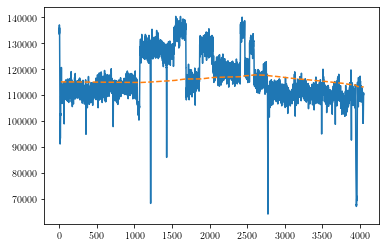

annot1:
  train: 0.8280130079529877
  test: 0.4682818908996243
annot2:
  train: 0.8280130079529877
  test: 0.4851996006972064
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8280130079529877
  test: 0.4747838096249867
annot4:
  train: 0.7293227239082162
  test: 0.5026539330725771
annot5:
  train: 0.6634470342259532


  3%|▎         | 104/4030 [00:00<00:03, 1035.40it/s]

  test: 0.578663722320452


100%|██████████| 4030/4030 [00:03<00:00, 1039.00it/s]


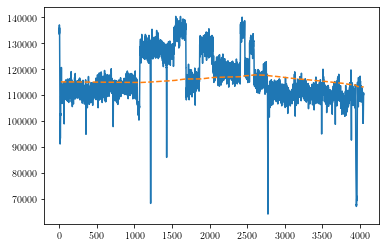

annot1:
  train: 0.8280130079529877
  test: 0.4682818908996243
annot2:
  train: 0.8280130079529877


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.4851996006972064
annot3:
  train: 0.8280130079529877
  test: 0.4747838096249867
annot4:
  train: 0.7293227239082162
  test: 0.5026539330725771
annot5:


  2%|▏         | 100/4030 [00:00<00:03, 996.55it/s]

  train: 0.6634470342259532
  test: 0.578663722320452


100%|██████████| 4030/4030 [00:03<00:00, 1015.97it/s]


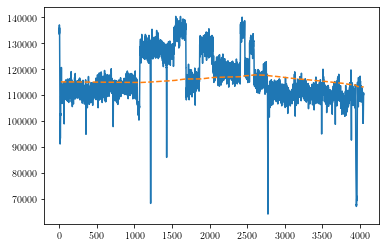

annot1:
  train: 0.8280130079529877
  test: 0.4682818908996243
annot2:
  train: 0.8280130079529877


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.4851996006972064
annot3:
  train: 0.8280130079529877
  test: 0.4747838096249867
annot4:
  train: 0.7293227239082162
  test: 0.5026539330725771
annot5:


  3%|▎         | 102/4030 [00:00<00:03, 1010.95it/s]

  train: 0.6634470342259532
  test: 0.578663722320452


100%|██████████| 4030/4030 [00:04<00:00, 959.20it/s] 


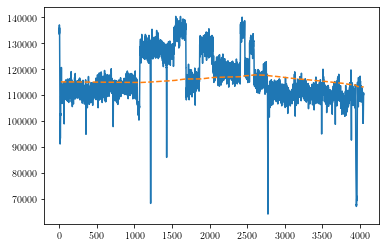

annot1:
  train: 0.8280130079529877
  test: 0.4682818908996243
annot2:
  train: 0.8280130079529877
  test: 0.4851996006972064
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8280130079529877
  test: 0.4747838096249867
annot4:
  train: 0.7293227239082162
  test: 0.5026539330725771
annot5:
  train: 0.6634470342259532


  3%|▎         | 103/4030 [00:00<00:03, 1026.85it/s]

  test: 0.578663722320452


100%|██████████| 4030/4030 [00:03<00:00, 1047.73it/s]


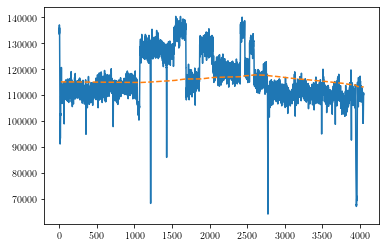

annot1:
  train: 0.8280130079529877
  test: 0.4682818908996243
annot2:
  train: 0.8280130079529877
  test: 0.4851996006972064
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8280130079529877
  test: 0.4747838096249867
annot4:
  train: 0.7293227239082162
  test: 0.5026539330725771
annot5:
  train: 0.6634470342259532


  2%|▏         | 99/4030 [00:00<00:03, 988.77it/s]

  test: 0.578663722320452


100%|██████████| 4030/4030 [00:03<00:00, 1025.71it/s]


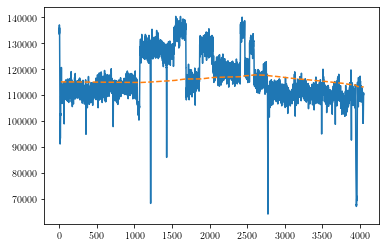

annot1:
  train: 0.8280130079529877
  test: 0.4682818908996243
annot2:
  train: 0.8280130079529877


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.4851996006972064
annot3:
  train: 0.8280130079529877
  test: 0.4747838096249867
annot4:
  train: 0.7293227239082162
  test: 0.5026539330725771
annot5:


  2%|▏         | 95/4030 [00:00<00:04, 942.17it/s]

  train: 0.6634470342259532
  test: 0.578663722320452


100%|██████████| 4030/4030 [00:04<00:00, 990.55it/s] 


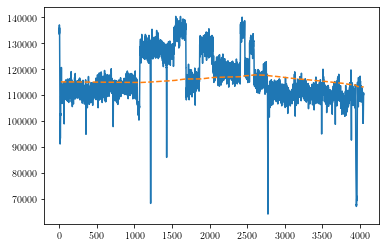

annot1:
  train: 0.8280130079529877
  test: 0.4682818908996243
annot2:
  train: 0.8280130079529877


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.4851996006972064
annot3:
  train: 0.8280130079529877
  test: 0.4747838096249867
annot4:
  train: 0.7293227239082162
  test: 0.5026539330725771
annot5:


  3%|▎         | 102/4030 [00:00<00:03, 1012.23it/s]

  train: 0.6634470342259532
  test: 0.578663722320452


100%|██████████| 4030/4030 [00:04<00:00, 1004.96it/s]


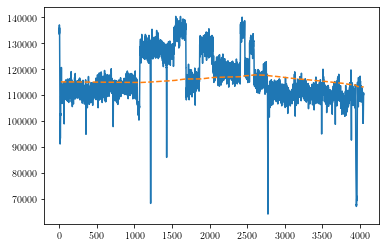

annot1:
  train: 0.8280130079529877
  test: 0.4682818908996243
annot2:
  train: 0.8280130079529877


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.4851996006972064
annot3:
  train: 0.8280130079529877
  test: 0.4747838096249867
annot4:
  train: 0.7293227239082162


  2%|▏         | 100/4030 [00:00<00:03, 994.54it/s]

  test: 0.5026539330725771
annot5:
  train: 0.6634470342259532
  test: 0.578663722320452
r = 0.003 , k = 1


100%|██████████| 4030/4030 [00:03<00:00, 1012.00it/s]


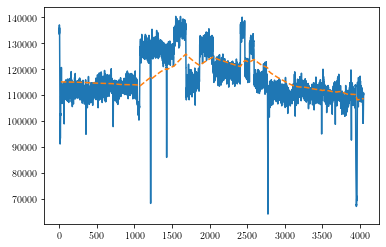

annot1:
  train: 0.8628125022196863
  test: 0.7793770458539944
annot2:
  train: 0.8628125022196863
  test: 0.7472728842983443
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8628125022196863
  test: 0.7470991530722247
annot4:
  train: 0.8179633604737232
  test: 0.7110529769665364
annot5:
  train: 0.6529975573171145


  5%|▍         | 200/4030 [00:00<00:03, 1000.91it/s]

  test: 0.6463646062699824


100%|██████████| 4030/4030 [00:03<00:00, 1032.97it/s]


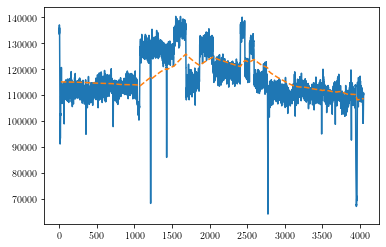

annot1:
  train: 0.8628125022196863
  test: 0.7793770458539944
annot2:
  train: 0.8628125022196863
  test: 0.7472728842983443
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8628125022196863
  test: 0.7470991530722247
annot4:
  train: 0.8179633604737232
  test: 0.7110529769665364
annot5:
  train: 0.6529975573171145


  5%|▌         | 209/4030 [00:00<00:03, 1032.14it/s]

  test: 0.6463646062699824


100%|██████████| 4030/4030 [00:03<00:00, 1058.56it/s]


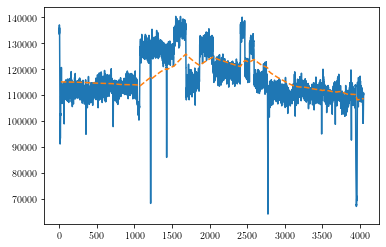

annot1:
  train: 0.8628125022196863
  test: 0.7793770458539944
annot2:
  train: 0.8628125022196863
  test: 0.7472728842983443
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8628125022196863
  test: 0.7470991530722247
annot4:
  train: 0.8179633604737232
  test: 0.7110529769665364
annot5:
  train: 0.6529975573171145


  5%|▌         | 206/4030 [00:00<00:03, 1011.36it/s]

  test: 0.6463646062699824


100%|██████████| 4030/4030 [00:03<00:00, 1021.38it/s]


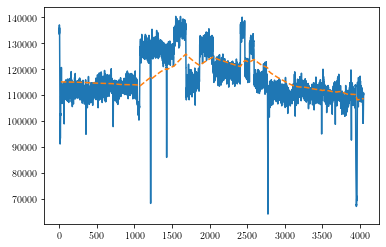

annot1:
  train: 0.8628125022196863
  test: 0.7793770458539944
annot2:
  train: 0.8628125022196863


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7472728842983443
annot3:
  train: 0.8628125022196863
  test: 0.7470991530722247
annot4:
  train: 0.8179633604737232
  test: 0.7110529769665364
annot5:


  3%|▎         | 102/4030 [00:00<00:03, 1016.29it/s]

  train: 0.6529975573171145
  test: 0.6463646062699824


100%|██████████| 4030/4030 [00:03<00:00, 1020.67it/s]


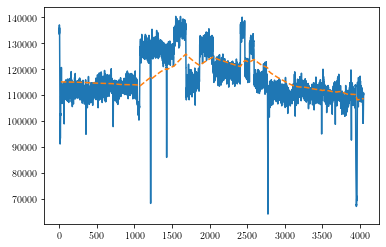

annot1:
  train: 0.8628125022196863
  test: 0.7793770458539944
annot2:
  train: 0.8628125022196863
  test: 0.7472728842983443
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8628125022196863
  test: 0.7470991530722247
annot4:
  train: 0.8179633604737232
  test: 0.7110529769665364
annot5:
  train: 0.6529975573171145


  3%|▎         | 102/4030 [00:00<00:03, 1017.69it/s]

  test: 0.6463646062699824


100%|██████████| 4030/4030 [00:03<00:00, 1058.66it/s]


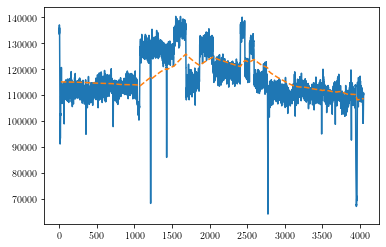

annot1:
  train: 0.8628125022196863
  test: 0.7793770458539944
annot2:
  train: 0.8628125022196863


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7472728842983443
annot3:
  train: 0.8628125022196863
  test: 0.7470991530722247
annot4:
  train: 0.8179633604737232


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.7110529769665364
annot5:
  train: 0.6529975573171145
  test: 0.6463646062699824


100%|██████████| 4030/4030 [00:04<00:00, 936.62it/s] 


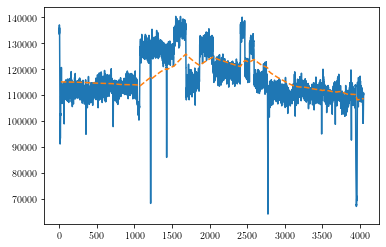

annot1:
  train: 0.8628125022196863
  test: 0.7793770458539944
annot2:
  train: 0.8628125022196863


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7472728842983443
annot3:
  train: 0.8628125022196863
  test: 0.7470991530722247
annot4:
  train: 0.8179633604737232
  test: 0.7110529769665364
annot5:


  2%|▏         | 95/4030 [00:00<00:04, 949.03it/s]

  train: 0.6529975573171145
  test: 0.6463646062699824


100%|██████████| 4030/4030 [00:03<00:00, 1074.65it/s]


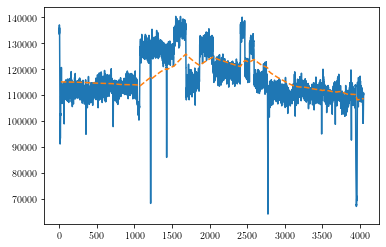

annot1:
  train: 0.8628125022196863
  test: 0.7793770458539944
annot2:
  train: 0.8628125022196863
  test: 0.7472728842983443
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8628125022196863
  test: 0.7470991530722247
annot4:
  train: 0.8179633604737232
  test: 0.7110529769665364
annot5:
  train: 0.6529975573171145


  5%|▌         | 216/4030 [00:00<00:03, 1075.81it/s]

  test: 0.6463646062699824


100%|██████████| 4030/4030 [00:03<00:00, 1073.55it/s]


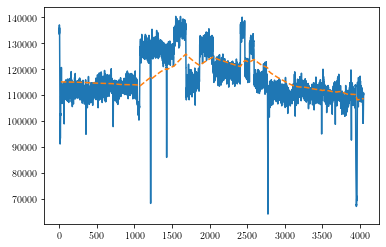

annot1:
  train: 0.8628125022196863
  test: 0.7793770458539944
annot2:
  train: 0.8628125022196863


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7472728842983443
annot3:
  train: 0.8628125022196863
  test: 0.7470991530722247
annot4:
  train: 0.8179633604737232
  test: 0.7110529769665364
annot5:


  3%|▎         | 107/4030 [00:00<00:03, 1068.40it/s]

  train: 0.6529975573171145
  test: 0.6463646062699824


100%|██████████| 4030/4030 [00:04<00:00, 967.49it/s] 


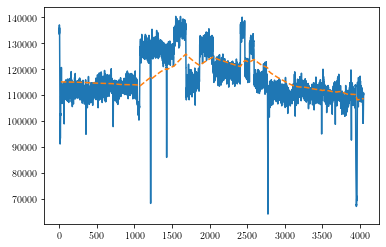

annot1:
  train: 0.8628125022196863
  test: 0.7793770458539944
annot2:
  train: 0.8628125022196863


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7472728842983443
annot3:
  train: 0.8628125022196863
  test: 0.7470991530722247
annot4:
  train: 0.8179633604737232
  test: 0.7110529769665364
annot5:


  3%|▎         | 104/4030 [00:00<00:03, 1031.62it/s]

  train: 0.6529975573171145
  test: 0.6463646062699824
r = 0.005 , k = 1


100%|██████████| 4030/4030 [00:04<00:00, 911.33it/s]


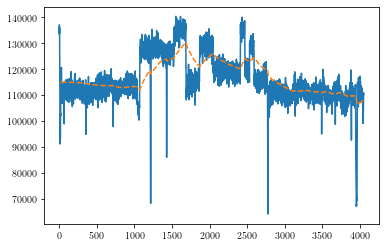

annot1:
  train: 0.8493904682531602
  test: 0.8039118876910112
annot2:
  train: 0.8493904682531602


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7750858623384389
annot3:
  train: 0.8493904682531602
  test: 0.7760394222848415
annot4:
  train: 0.824679422649889
  test: 0.6991765102129507
annot5:


  3%|▎         | 102/4030 [00:00<00:03, 1016.34it/s]

  train: 0.6321096661012281
  test: 0.745018844219864


100%|██████████| 4030/4030 [00:04<00:00, 912.58it/s]


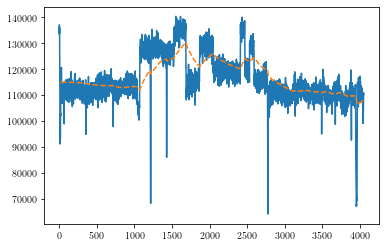

annot1:
  train: 0.8493904682531602
  test: 0.8039118876910112
annot2:
  train: 0.8493904682531602


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7750858623384389
annot3:
  train: 0.8493904682531602
  test: 0.7760394222848415
annot4:
  train: 0.824679422649889


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.6991765102129507
annot5:
  train: 0.6321096661012281
  test: 0.745018844219864


100%|██████████| 4030/4030 [00:05<00:00, 799.63it/s]


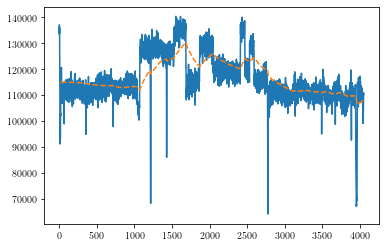

annot1:
  train: 0.8493904682531602
  test: 0.8039118876910112
annot2:
  train: 0.8493904682531602


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7750858623384389
annot3:
  train: 0.8493904682531602
  test: 0.7760394222848415
annot4:
  train: 0.824679422649889


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.6991765102129507
annot5:
  train: 0.6321096661012281
  test: 0.745018844219864


100%|██████████| 4030/4030 [00:05<00:00, 794.30it/s]


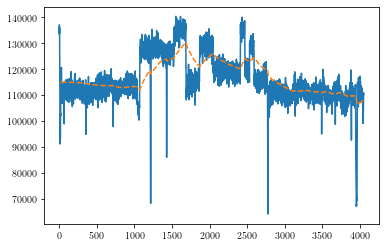

annot1:
  train: 0.8493904682531602
  test: 0.8039118876910112
annot2:
  train: 0.8493904682531602


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7750858623384389
annot3:
  train: 0.8493904682531602
  test: 0.7760394222848415
annot4:
  train: 0.824679422649889
  test: 0.6991765102129507
annot5:


  2%|▏         | 93/4030 [00:00<00:04, 922.19it/s]

  train: 0.6321096661012281
  test: 0.745018844219864


100%|██████████| 4030/4030 [00:04<00:00, 835.26it/s]


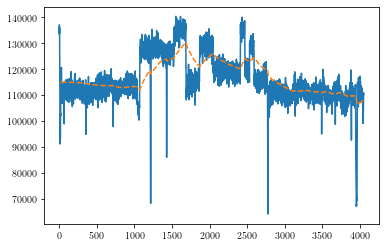

annot1:
  train: 0.8493904682531602
  test: 0.8039118876910112
annot2:
  train: 0.8493904682531602


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7750858623384389
annot3:
  train: 0.8493904682531602
  test: 0.7760394222848415
annot4:
  train: 0.824679422649889


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.6991765102129507
annot5:
  train: 0.6321096661012281
  test: 0.745018844219864


100%|██████████| 4030/4030 [00:05<00:00, 805.42it/s]


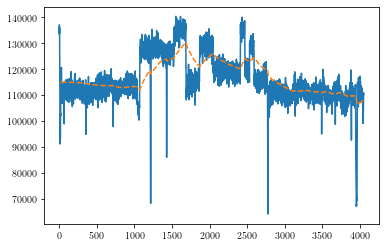

annot1:
  train: 0.8493904682531602
  test: 0.8039118876910112
annot2:
  train: 0.8493904682531602


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7750858623384389
annot3:
  train: 0.8493904682531602
  test: 0.7760394222848415
annot4:
  train: 0.824679422649889


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.6991765102129507
annot5:
  train: 0.6321096661012281
  test: 0.745018844219864


100%|██████████| 4030/4030 [00:04<00:00, 876.79it/s]


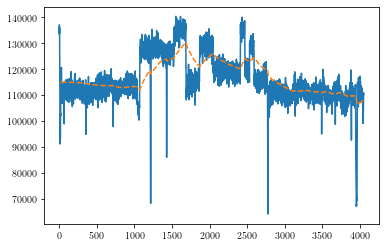

annot1:
  train: 0.8493904682531602
  test: 0.8039118876910112
annot2:
  train: 0.8493904682531602


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7750858623384389
annot3:
  train: 0.8493904682531602
  test: 0.7760394222848415
annot4:
  train: 0.824679422649889
  test: 0.6991765102129507
annot5:


  2%|▏         | 97/4030 [00:00<00:04, 964.55it/s]

  train: 0.6321096661012281
  test: 0.745018844219864


100%|██████████| 4030/4030 [00:04<00:00, 968.50it/s] 


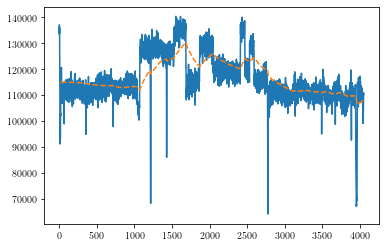

annot1:
  train: 0.8493904682531602
  test: 0.8039118876910112
annot2:
  train: 0.8493904682531602


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.7750858623384389
annot3:
  train: 0.8493904682531602
  test: 0.7760394222848415
annot4:
  train: 0.824679422649889
  test: 0.6991765102129507
annot5:


  3%|▎         | 104/4030 [00:00<00:03, 1037.52it/s]

  train: 0.6321096661012281
  test: 0.745018844219864


100%|██████████| 4030/4030 [00:04<00:00, 993.48it/s] 


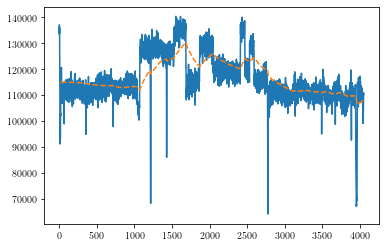

annot1:
  train: 0.8493904682531602
  test: 0.8039118876910112
annot2:
  train: 0.8493904682531602
  test: 0.7750858623384389
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8493904682531602
  test: 0.7760394222848415
annot4:
  train: 0.824679422649889
  test: 0.6991765102129507
annot5:
  train: 0.6321096661012281


  3%|▎         | 115/4030 [00:00<00:03, 1139.89it/s]

  test: 0.745018844219864


100%|██████████| 4030/4030 [00:03<00:00, 1020.23it/s]


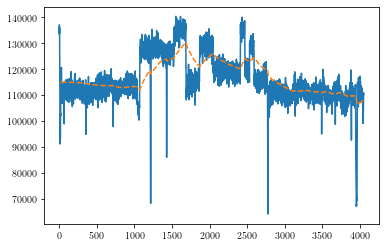

annot1:
  train: 0.8493904682531602
  test: 0.8039118876910112
annot2:
  train: 0.8493904682531602
  test: 0.7750858623384389
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8493904682531602
  test: 0.7760394222848415
annot4:
  train: 0.824679422649889
  test: 0.6991765102129507
annot5:
  train: 0.6321096661012281


  3%|▎         | 110/4030 [00:00<00:03, 1099.80it/s]

  test: 0.745018844219864
r = 0.01 , k = 1


100%|██████████| 4030/4030 [00:03<00:00, 1092.15it/s]


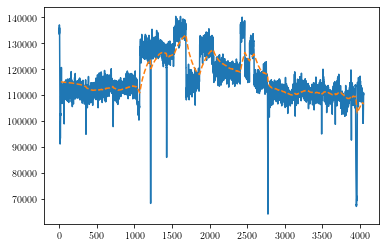

annot1:
  train: 0.8089676269127777
  test: 0.7999057284208878
annot2:
  train: 0.8089676269127777
  test: 0.7699084925270586
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8089676269127777
  test: 0.7711945565341269
annot4:
  train: 0.7738461509992597
  test: 0.6979966318991744
annot5:
  train: 0.5925851042557716


  3%|▎         | 115/4030 [00:00<00:03, 1145.15it/s]

  test: 0.7502830388383179


100%|██████████| 4030/4030 [00:03<00:00, 1119.30it/s]


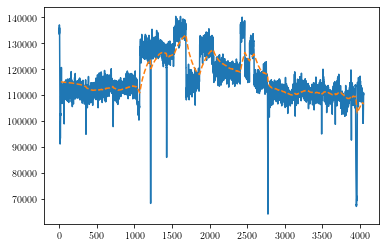

annot1:
  train: 0.8089676269127777
  test: 0.7999057284208878
annot2:
  train: 0.8089676269127777
  test: 0.7699084925270586
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8089676269127777
  test: 0.7711945565341269
annot4:
  train: 0.7738461509992597
  test: 0.6979966318991744
annot5:
  train: 0.5925851042557716


  3%|▎         | 118/4030 [00:00<00:03, 1172.61it/s]

  test: 0.7502830388383179


100%|██████████| 4030/4030 [00:03<00:00, 1157.80it/s]


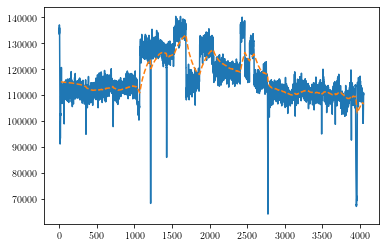

annot1:
  train: 0.8089676269127777
  test: 0.7999057284208878
annot2:
  train: 0.8089676269127777
  test: 0.7699084925270586
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8089676269127777
  test: 0.7711945565341269
annot4:
  train: 0.7738461509992597
  test: 0.6979966318991744
annot5:
  train: 0.5925851042557716


  3%|▎         | 116/4030 [00:00<00:03, 1156.71it/s]

  test: 0.7502830388383179


100%|██████████| 4030/4030 [00:03<00:00, 1178.60it/s]


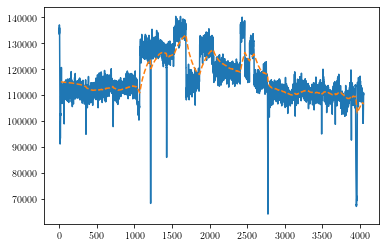

annot1:
  train: 0.8089676269127777
  test: 0.7999057284208878
annot2:
  train: 0.8089676269127777
  test: 0.7699084925270586
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8089676269127777
  test: 0.7711945565341269
annot4:
  train: 0.7738461509992597
  test: 0.6979966318991744
annot5:
  train: 0.5925851042557716


  6%|▌         | 250/4030 [00:00<00:03, 1247.17it/s]

  test: 0.7502830388383179


100%|██████████| 4030/4030 [00:03<00:00, 1233.43it/s]


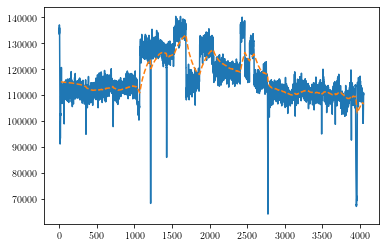

annot1:
  train: 0.8089676269127777
  test: 0.7999057284208878
annot2:
  train: 0.8089676269127777
  test: 0.7699084925270586
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8089676269127777
  test: 0.7711945565341269
annot4:
  train: 0.7738461509992597
  test: 0.6979966318991744
annot5:
  train: 0.5925851042557716


  6%|▌         | 244/4030 [00:00<00:03, 1206.82it/s]

  test: 0.7502830388383179


100%|██████████| 4030/4030 [00:03<00:00, 1207.90it/s]


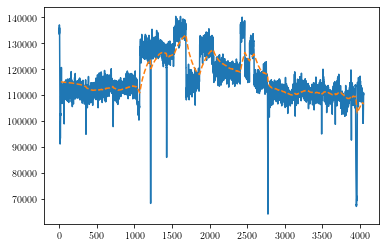

annot1:
  train: 0.8089676269127777
  test: 0.7999057284208878
annot2:
  train: 0.8089676269127777
  test: 0.7699084925270586
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8089676269127777
  test: 0.7711945565341269
annot4:
  train: 0.7738461509992597
  test: 0.6979966318991744
annot5:
  train: 0.5925851042557716


  6%|▌         | 242/4030 [00:00<00:03, 1200.28it/s]

  test: 0.7502830388383179


100%|██████████| 4030/4030 [00:03<00:00, 1207.40it/s]


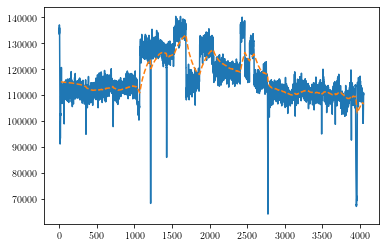

annot1:
  train: 0.8089676269127777
  test: 0.7999057284208878
annot2:
  train: 0.8089676269127777
  test: 0.7699084925270586
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8089676269127777
  test: 0.7711945565341269
annot4:
  train: 0.7738461509992597
  test: 0.6979966318991744
annot5:
  train: 0.5925851042557716


  3%|▎         | 124/4030 [00:00<00:03, 1233.99it/s]

  test: 0.7502830388383179


100%|██████████| 4030/4030 [00:03<00:00, 1238.35it/s]


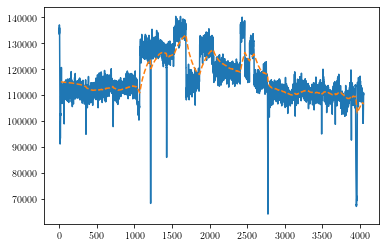

annot1:
  train: 0.8089676269127777
  test: 0.7999057284208878
annot2:
  train: 0.8089676269127777
  test: 0.7699084925270586
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8089676269127777
  test: 0.7711945565341269
annot4:
  train: 0.7738461509992597
  test: 0.6979966318991744
annot5:
  train: 0.5925851042557716


  3%|▎         | 122/4030 [00:00<00:03, 1216.79it/s]

  test: 0.7502830388383179


100%|██████████| 4030/4030 [00:03<00:00, 1126.86it/s]


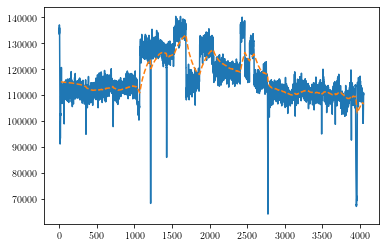

annot1:
  train: 0.8089676269127777
  test: 0.7999057284208878
annot2:
  train: 0.8089676269127777
  test: 0.7699084925270586
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8089676269127777
  test: 0.7711945565341269
annot4:
  train: 0.7738461509992597
  test: 0.6979966318991744
annot5:
  train: 0.5925851042557716


  3%|▎         | 121/4030 [00:00<00:03, 1202.27it/s]

  test: 0.7502830388383179


100%|██████████| 4030/4030 [00:03<00:00, 1189.93it/s]


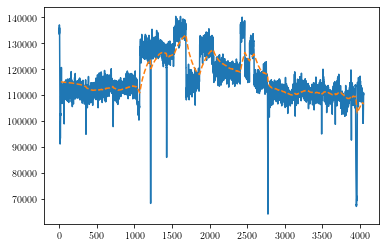

annot1:
  train: 0.8089676269127777
  test: 0.7999057284208878
annot2:
  train: 0.8089676269127777
  test: 0.7699084925270586
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8089676269127777
  test: 0.7711945565341269
annot4:
  train: 0.7738461509992597
  test: 0.6979966318991744
annot5:
  train: 0.5925851042557716


  6%|▌         | 248/4030 [00:00<00:03, 1228.85it/s]

  test: 0.7502830388383179
r = 0.03 , k = 1


100%|██████████| 4030/4030 [00:03<00:00, 1205.82it/s]


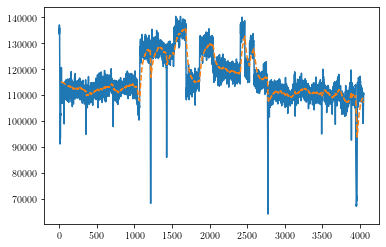

annot1:
  train: 0.7620145516707431
  test: 0.6766384769430346
annot2:
  train: 0.7620145516707431
  test: 0.655563885824576
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.7620145516707431
  test: 0.6590430534680847
annot4:
  train: 0.732283197631384
  test: 0.6807846153846153
annot5:
  train: 0.556536559142708


  3%|▎         | 115/4030 [00:00<00:03, 1147.67it/s]

  test: 0.7119414059532634


100%|██████████| 4030/4030 [00:03<00:00, 1137.94it/s]


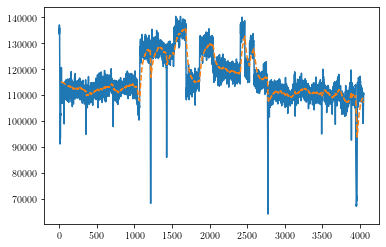

annot1:
  train: 0.7620145516707431
  test: 0.6766384769430346
annot2:
  train: 0.7620145516707431
  test: 0.655563885824576
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.7620145516707431
  test: 0.6590430534680847
annot4:
  train: 0.732283197631384
  test: 0.6807846153846153
annot5:
  train: 0.556536559142708


  3%|▎         | 113/4030 [00:00<00:03, 1128.15it/s]

  test: 0.7119414059532634


100%|██████████| 4030/4030 [00:03<00:00, 1102.38it/s]


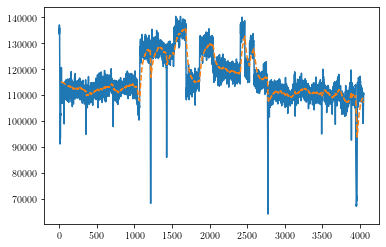

annot1:
  train: 0.7620145516707431
  test: 0.6766384769430346
annot2:
  train: 0.7620145516707431


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.655563885824576
annot3:
  train: 0.7620145516707431
  test: 0.6590430534680847
annot4:
  train: 0.732283197631384
  test: 0.6807846153846153
annot5:


  2%|▏         | 94/4030 [00:00<00:04, 932.67it/s]

  train: 0.556536559142708
  test: 0.7119414059532634


100%|██████████| 4030/4030 [00:04<00:00, 987.05it/s] 


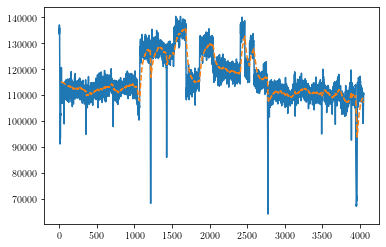

annot1:
  train: 0.7620145516707431
  test: 0.6766384769430346
annot2:
  train: 0.7620145516707431


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.655563885824576
annot3:
  train: 0.7620145516707431
  test: 0.6590430534680847
annot4:
  train: 0.732283197631384
  test: 0.6807846153846153
annot5:


  2%|▏         | 78/4030 [00:00<00:05, 777.10it/s]

  train: 0.556536559142708
  test: 0.7119414059532634


100%|██████████| 4030/4030 [00:04<00:00, 986.60it/s] 


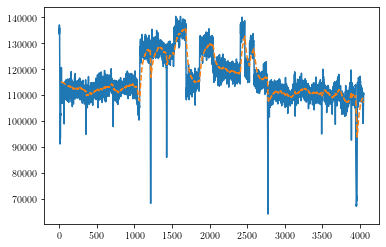

annot1:
  train: 0.7620145516707431
  test: 0.6766384769430346
annot2:
  train: 0.7620145516707431


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.655563885824576
annot3:
  train: 0.7620145516707431
  test: 0.6590430534680847
annot4:
  train: 0.732283197631384


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.6807846153846153
annot5:
  train: 0.556536559142708
  test: 0.7119414059532634


100%|██████████| 4030/4030 [00:03<00:00, 1018.96it/s]


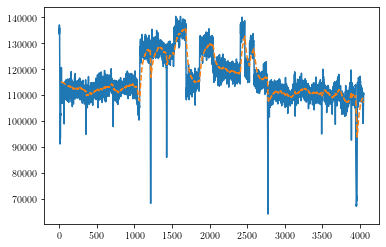

annot1:
  train: 0.7620145516707431
  test: 0.6766384769430346
annot2:
  train: 0.7620145516707431
  test: 0.655563885824576
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.7620145516707431
  test: 0.6590430534680847
annot4:
  train: 0.732283197631384
  test: 0.6807846153846153
annot5:
  train: 0.556536559142708


  5%|▌         | 211/4030 [00:00<00:03, 1038.18it/s]

  test: 0.7119414059532634


100%|██████████| 4030/4030 [00:04<00:00, 1003.35it/s]


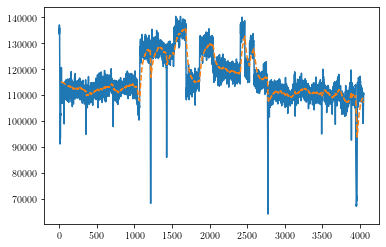

annot1:
  train: 0.7620145516707431
  test: 0.6766384769430346
annot2:
  train: 0.7620145516707431


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.655563885824576
annot3:
  train: 0.7620145516707431
  test: 0.6590430534680847
annot4:
  train: 0.732283197631384


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.6807846153846153
annot5:
  train: 0.556536559142708
  test: 0.7119414059532634


100%|██████████| 4030/4030 [00:04<00:00, 999.63it/s] 


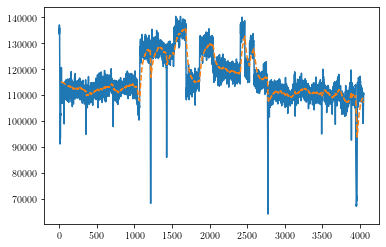

annot1:
  train: 0.7620145516707431
  test: 0.6766384769430346
annot2:
  train: 0.7620145516707431


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.655563885824576
annot3:
  train: 0.7620145516707431
  test: 0.6590430534680847
annot4:
  train: 0.732283197631384
  test: 0.6807846153846153
annot5:


  2%|▏         | 94/4030 [00:00<00:04, 937.99it/s]

  train: 0.556536559142708
  test: 0.7119414059532634


100%|██████████| 4030/4030 [00:03<00:00, 1037.88it/s]


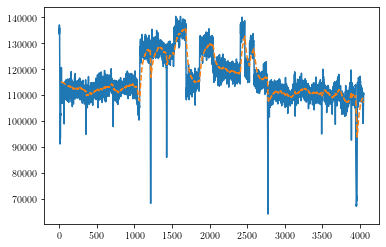

annot1:
  train: 0.7620145516707431
  test: 0.6766384769430346
annot2:
  train: 0.7620145516707431


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.655563885824576
annot3:
  train: 0.7620145516707431
  test: 0.6590430534680847
annot4:
  train: 0.732283197631384
  test: 0.6807846153846153
annot5:


  3%|▎         | 102/4030 [00:00<00:03, 1014.43it/s]

  train: 0.556536559142708
  test: 0.7119414059532634


100%|██████████| 4030/4030 [00:03<00:00, 1019.01it/s]


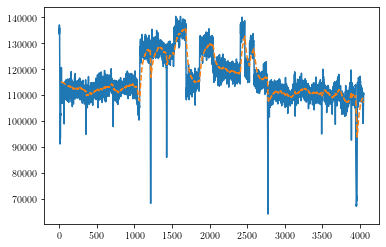

annot1:
  train: 0.7620145516707431
  test: 0.6766384769430346
annot2:
  train: 0.7620145516707431
  test: 0.655563885824576
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.7620145516707431
  test: 0.6590430534680847
annot4:
  train: 0.732283197631384
  test: 0.6807846153846153
annot5:
  train: 0.556536559142708


  3%|▎         | 117/4030 [00:00<00:03, 1163.46it/s]

  test: 0.7119414059532634
r = 0.05 , k = 1


100%|██████████| 4030/4030 [00:03<00:00, 1093.68it/s]


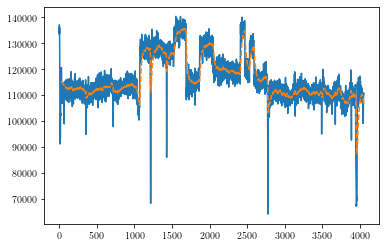

annot1:
  train: 0.704840194432672
  test: 0.6323095144129178
annot2:
  train: 0.704840194432672


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.61284982263893
annot3:
  train: 0.704840194432672
  test: 0.6150837296867081
annot4:
  train: 0.7049026646928203


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.6644431116905694
annot5:
  train: 0.5305294395089383
  test: 0.673045258081546


100%|██████████| 4030/4030 [00:03<00:00, 1061.72it/s]


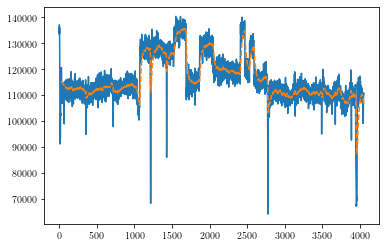

annot1:
  train: 0.704840194432672
  test: 0.6323095144129178
annot2:
  train: 0.704840194432672
  test: 0.61284982263893
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.704840194432672
  test: 0.6150837296867081
annot4:
  train: 0.7049026646928203
  test: 0.6644431116905694
annot5:
  train: 0.5305294395089383


  3%|▎         | 111/4030 [00:00<00:03, 1104.78it/s]

  test: 0.673045258081546


100%|██████████| 4030/4030 [00:03<00:00, 1080.70it/s]


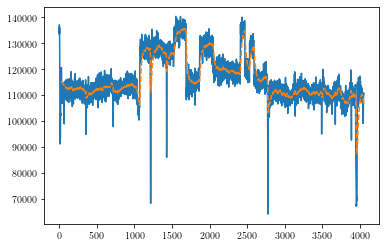

annot1:
  train: 0.704840194432672
  test: 0.6323095144129178
annot2:
  train: 0.704840194432672


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.61284982263893
annot3:
  train: 0.704840194432672
  test: 0.6150837296867081
annot4:
  train: 0.7049026646928203
  test: 0.6644431116905694
annot5:
  train: 0.5305294395089383


  5%|▌         | 219/4030 [00:00<00:03, 1071.91it/s]

  test: 0.673045258081546


100%|██████████| 4030/4030 [00:03<00:00, 1088.09it/s]


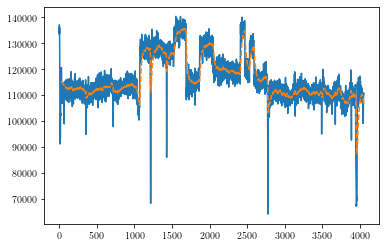

annot1:
  train: 0.704840194432672
  test: 0.6323095144129178
annot2:
  train: 0.704840194432672
  test: 0.61284982263893
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.704840194432672
  test: 0.6150837296867081
annot4:
  train: 0.7049026646928203
  test: 0.6644431116905694
annot5:
  train: 0.5305294395089383


  3%|▎         | 108/4030 [00:00<00:03, 1076.30it/s]

  test: 0.673045258081546


100%|██████████| 4030/4030 [00:03<00:00, 1038.94it/s]


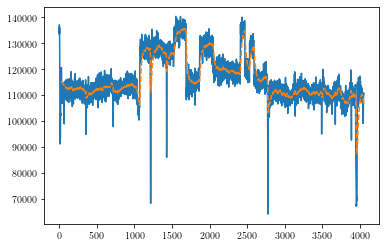

annot1:
  train: 0.704840194432672
  test: 0.6323095144129178
annot2:
  train: 0.704840194432672


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.61284982263893
annot3:
  train: 0.704840194432672
  test: 0.6150837296867081
annot4:
  train: 0.7049026646928203
  test: 0.6644431116905694
annot5:


  3%|▎         | 108/4030 [00:00<00:03, 1079.45it/s]

  train: 0.5305294395089383
  test: 0.673045258081546


100%|██████████| 4030/4030 [00:03<00:00, 1025.78it/s]


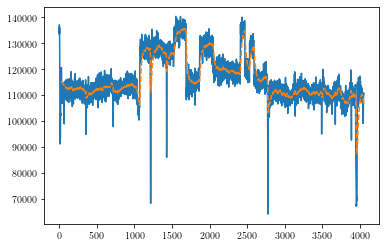

annot1:
  train: 0.704840194432672
  test: 0.6323095144129178
annot2:
  train: 0.704840194432672


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.61284982263893
annot3:
  train: 0.704840194432672
  test: 0.6150837296867081
annot4:
  train: 0.7049026646928203
  test: 0.6644431116905694
annot5:


  3%|▎         | 102/4030 [00:00<00:03, 1017.01it/s]

  train: 0.5305294395089383
  test: 0.673045258081546


100%|██████████| 4030/4030 [00:04<00:00, 997.02it/s] 


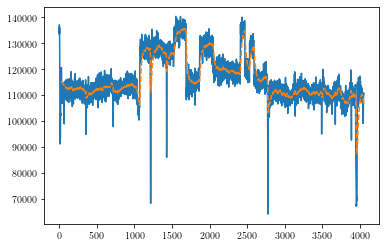

annot1:
  train: 0.704840194432672
  test: 0.6323095144129178
annot2:
  train: 0.704840194432672
  test: 0.61284982263893
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.704840194432672
  test: 0.6150837296867081
annot4:
  train: 0.7049026646928203
  test: 0.6644431116905694
annot5:
  train: 0.5305294395089383


  3%|▎         | 104/4030 [00:00<00:03, 1037.50it/s]

  test: 0.673045258081546


100%|██████████| 4030/4030 [00:03<00:00, 1143.04it/s]


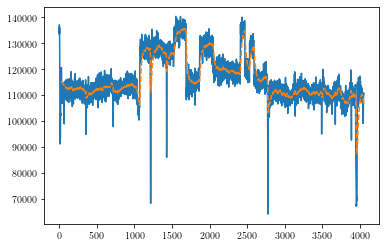

annot1:
  train: 0.704840194432672
  test: 0.6323095144129178
annot2:
  train: 0.704840194432672
  test: 0.61284982263893
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.704840194432672
  test: 0.6150837296867081
annot4:
  train: 0.7049026646928203
  test: 0.6644431116905694
annot5:
  train: 0.5305294395089383


  3%|▎         | 117/4030 [00:00<00:03, 1167.95it/s]

  test: 0.673045258081546


100%|██████████| 4030/4030 [00:03<00:00, 1084.76it/s]


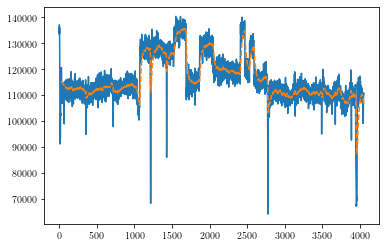

annot1:
  train: 0.704840194432672
  test: 0.6323095144129178
annot2:
  train: 0.704840194432672


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.61284982263893
annot3:
  train: 0.704840194432672
  test: 0.6150837296867081
annot4:
  train: 0.7049026646928203
  test: 0.6644431116905694
annot5:


  2%|▏         | 93/4030 [00:00<00:04, 926.08it/s]

  train: 0.5305294395089383
  test: 0.673045258081546


100%|██████████| 4030/4030 [00:04<00:00, 888.42it/s]


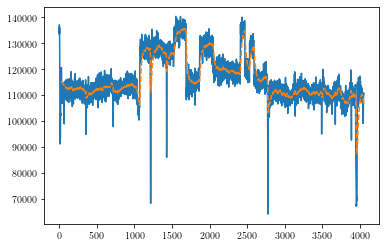

annot1:
  train: 0.704840194432672
  test: 0.6323095144129178
annot2:
  train: 0.704840194432672


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.61284982263893
annot3:
  train: 0.704840194432672
  test: 0.6150837296867081
annot4:
  train: 0.7049026646928203
  test: 0.6644431116905694
annot5:


  3%|▎         | 101/4030 [00:00<00:03, 1006.65it/s]

  train: 0.5305294395089383
  test: 0.673045258081546
r = 0.1 , k = 1


100%|██████████| 4030/4030 [00:04<00:00, 968.93it/s] 


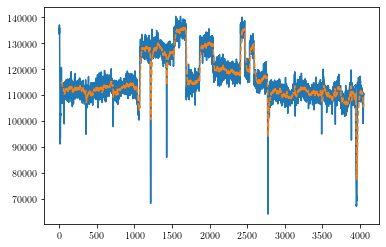

annot1:
  train: 0.6075112760058435
  test: 0.5731903431103959
annot2:
  train: 0.6075112760058435
  test: 0.54787343290262
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.6075112760058435
  test: 0.5493910235756966
annot4:
  train: 0.6208078460399704
  test: 0.6400673620165145
annot5:
  train: 0.4999416098509561


  3%|▎         | 107/4030 [00:00<00:03, 1066.35it/s]

  test: 0.6188019699265964


100%|██████████| 4030/4030 [00:03<00:00, 1088.39it/s]


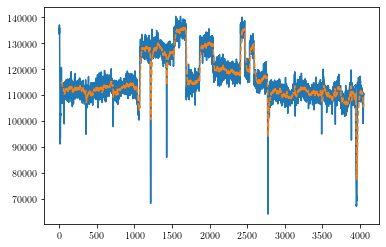

annot1:
  train: 0.6075112760058435
  test: 0.5731903431103959
annot2:
  train: 0.6075112760058435
  test: 0.54787343290262
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.6075112760058435
  test: 0.5493910235756966
annot4:
  train: 0.6208078460399704
  test: 0.6400673620165145
annot5:
  train: 0.4999416098509561


  6%|▌         | 227/4030 [00:00<00:03, 1138.29it/s]

  test: 0.6188019699265964


100%|██████████| 4030/4030 [00:03<00:00, 1059.13it/s]


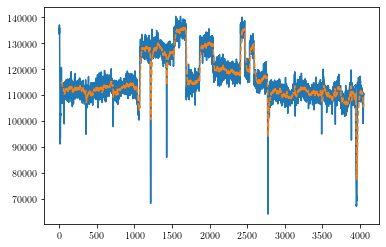

annot1:
  train: 0.6075112760058435
  test: 0.5731903431103959
annot2:
  train: 0.6075112760058435
  test: 0.54787343290262
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.6075112760058435
  test: 0.5493910235756966
annot4:
  train: 0.6208078460399704
  test: 0.6400673620165145
annot5:
  train: 0.4999416098509561


  3%|▎         | 107/4030 [00:00<00:03, 1063.88it/s]

  test: 0.6188019699265964


100%|██████████| 4030/4030 [00:03<00:00, 1111.09it/s]


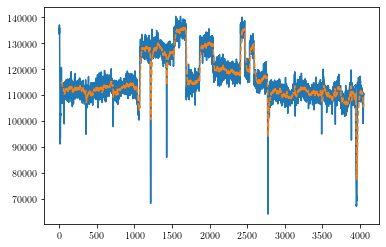

annot1:
  train: 0.6075112760058435
  test: 0.5731903431103959
annot2:
  train: 0.6075112760058435
  test: 0.54787343290262
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.6075112760058435
  test: 0.5493910235756966
annot4:
  train: 0.6208078460399704
  test: 0.6400673620165145
annot5:
  train: 0.4999416098509561


  3%|▎         | 113/4030 [00:00<00:03, 1129.72it/s]

  test: 0.6188019699265964


100%|██████████| 4030/4030 [00:03<00:00, 1055.68it/s]


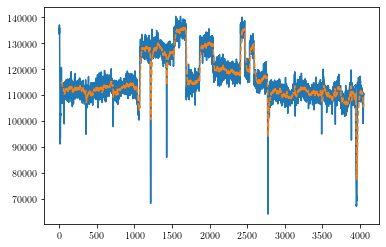

annot1:
  train: 0.6075112760058435
  test: 0.5731903431103959
annot2:
  train: 0.6075112760058435


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.54787343290262
annot3:
  train: 0.6075112760058435
  test: 0.5493910235756966
annot4:
  train: 0.6208078460399704
  test: 0.6400673620165145
annot5:


  3%|▎         | 112/4030 [00:00<00:03, 1116.66it/s]

  train: 0.4999416098509561
  test: 0.6188019699265964


100%|██████████| 4030/4030 [00:03<00:00, 1045.83it/s]


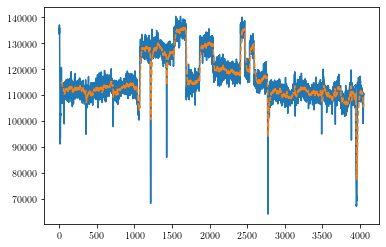

annot1:
  train: 0.6075112760058435
  test: 0.5731903431103959
annot2:
  train: 0.6075112760058435


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.54787343290262
annot3:
  train: 0.6075112760058435
  test: 0.5493910235756966
annot4:
  train: 0.6208078460399704
  test: 0.6400673620165145
annot5:


  3%|▎         | 105/4030 [00:00<00:03, 1040.91it/s]

  train: 0.4999416098509561
  test: 0.6188019699265964


100%|██████████| 4030/4030 [00:04<00:00, 999.13it/s] 


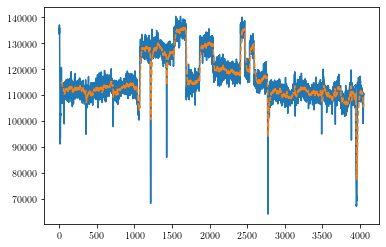

annot1:
  train: 0.6075112760058435
  test: 0.5731903431103959
annot2:
  train: 0.6075112760058435


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.54787343290262
annot3:
  train: 0.6075112760058435
  test: 0.5493910235756966
annot4:
  train: 0.6208078460399704
  test: 0.6400673620165145
annot5:


  3%|▎         | 102/4030 [00:00<00:03, 1013.89it/s]

  train: 0.4999416098509561
  test: 0.6188019699265964


100%|██████████| 4030/4030 [00:03<00:00, 1017.75it/s]


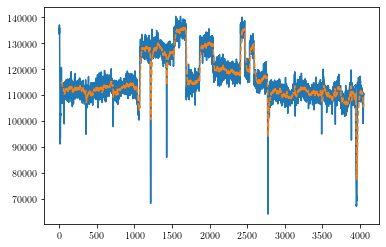

annot1:
  train: 0.6075112760058435
  test: 0.5731903431103959
annot2:
  train: 0.6075112760058435


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.54787343290262
annot3:
  train: 0.6075112760058435
  test: 0.5493910235756966
annot4:
  train: 0.6208078460399704
  test: 0.6400673620165145
annot5:


  3%|▎         | 107/4030 [00:00<00:03, 1058.12it/s]

  train: 0.4999416098509561
  test: 0.6188019699265964


100%|██████████| 4030/4030 [00:04<00:00, 956.83it/s] 


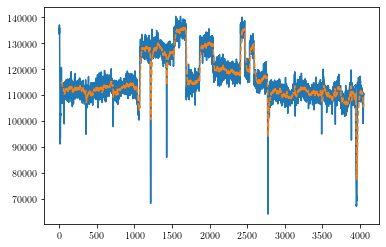

annot1:
  train: 0.6075112760058435
  test: 0.5731903431103959
annot2:
  train: 0.6075112760058435


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.54787343290262
annot3:
  train: 0.6075112760058435
  test: 0.5493910235756966
annot4:
  train: 0.6208078460399704
  test: 0.6400673620165145
annot5:


  3%|▎         | 101/4030 [00:00<00:03, 1009.79it/s]

  train: 0.4999416098509561
  test: 0.6188019699265964


100%|██████████| 4030/4030 [00:03<00:00, 1026.60it/s]


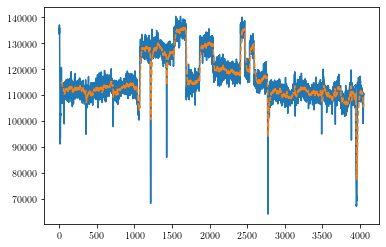

annot1:
  train: 0.6075112760058435
  test: 0.5731903431103959
annot2:
  train: 0.6075112760058435


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.54787343290262
annot3:
  train: 0.6075112760058435
  test: 0.5493910235756966
annot4:
  train: 0.6208078460399704
  test: 0.6400673620165145
annot5:


  5%|▌         | 206/4030 [00:00<00:03, 1035.83it/s]

  train: 0.4999416098509561
  test: 0.6188019699265964
r = 0.3 , k = 1


100%|██████████| 4030/4030 [00:03<00:00, 1017.46it/s]


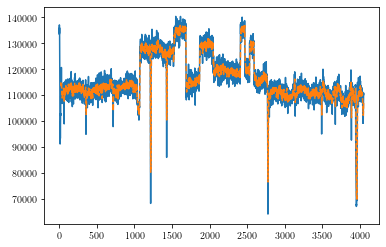

annot1:
  train: 0.5090777943777421
  test: 0.5372786999103029
annot2:
  train: 0.5090777943777421


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.521648197455581
annot3:
  train: 0.5090777943777421
  test: 0.5226567443350928
annot4:
  train: 0.5086431162102146
  test: 0.5674770099956541
annot5:


  3%|▎         | 107/4030 [00:00<00:03, 1060.51it/s]

  train: 0.4605753036212238
  test: 0.5609943425833316


100%|██████████| 4030/4030 [00:03<00:00, 1074.07it/s]


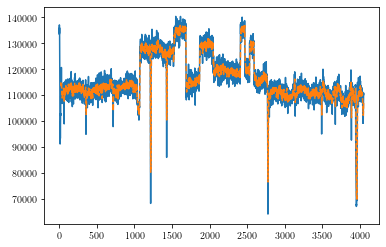

annot1:
  train: 0.5090777943777421
  test: 0.5372786999103029
annot2:
  train: 0.5090777943777421
  test: 0.521648197455581
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.5090777943777421
  test: 0.5226567443350928
annot4:
  train: 0.5086431162102146
  test: 0.5674770099956541
annot5:
  train: 0.4605753036212238


  3%|▎         | 115/4030 [00:00<00:03, 1143.63it/s]

  test: 0.5609943425833316


100%|██████████| 4030/4030 [00:03<00:00, 1105.29it/s]


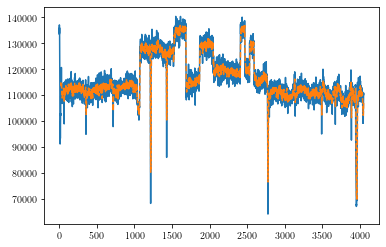

annot1:
  train: 0.5090777943777421
  test: 0.5372786999103029
annot2:
  train: 0.5090777943777421
  test: 0.521648197455581
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.5090777943777421
  test: 0.5226567443350928
annot4:
  train: 0.5086431162102146
  test: 0.5674770099956541
annot5:
  train: 0.4605753036212238


  3%|▎         | 112/4030 [00:00<00:03, 1118.21it/s]

  test: 0.5609943425833316


100%|██████████| 4030/4030 [00:03<00:00, 1096.44it/s]


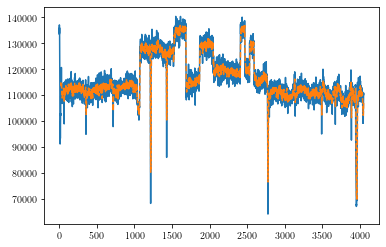

annot1:
  train: 0.5090777943777421
  test: 0.5372786999103029
annot2:
  train: 0.5090777943777421
  test: 0.521648197455581
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.5090777943777421
  test: 0.5226567443350928
annot4:
  train: 0.5086431162102146
  test: 0.5674770099956541
annot5:
  train: 0.4605753036212238


  3%|▎         | 112/4030 [00:00<00:03, 1119.67it/s]

  test: 0.5609943425833316


100%|██████████| 4030/4030 [00:03<00:00, 1094.93it/s]


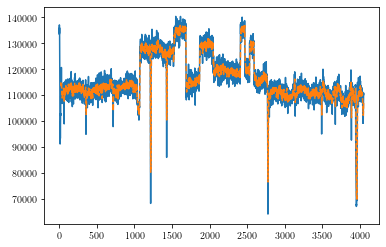

annot1:
  train: 0.5090777943777421
  test: 0.5372786999103029
annot2:
  train: 0.5090777943777421


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.521648197455581
annot3:
  train: 0.5090777943777421
  test: 0.5226567443350928
annot4:
  train: 0.5086431162102146
  test: 0.5674770099956541
annot5:


  3%|▎         | 108/4030 [00:00<00:03, 1076.66it/s]

  train: 0.4605753036212238
  test: 0.5609943425833316


100%|██████████| 4030/4030 [00:03<00:00, 1059.07it/s]


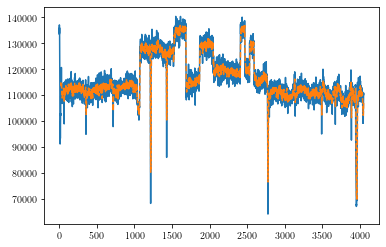

annot1:
  train: 0.5090777943777421
  test: 0.5372786999103029
annot2:
  train: 0.5090777943777421


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.521648197455581
annot3:
  train: 0.5090777943777421
  test: 0.5226567443350928
annot4:
  train: 0.5086431162102146
  test: 0.5674770099956541
annot5:


  3%|▎         | 107/4030 [00:00<00:03, 1060.41it/s]

  train: 0.4605753036212238
  test: 0.5609943425833316


100%|██████████| 4030/4030 [00:03<00:00, 1063.19it/s]


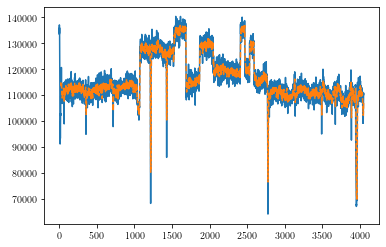

annot1:
  train: 0.5090777943777421
  test: 0.5372786999103029
annot2:
  train: 0.5090777943777421
  test: 0.521648197455581
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.5090777943777421
  test: 0.5226567443350928
annot4:
  train: 0.5086431162102146
  test: 0.5674770099956541
annot5:
  train: 0.4605753036212238


  3%|▎         | 111/4030 [00:00<00:03, 1106.01it/s]

  test: 0.5609943425833316


100%|██████████| 4030/4030 [00:03<00:00, 1064.27it/s]


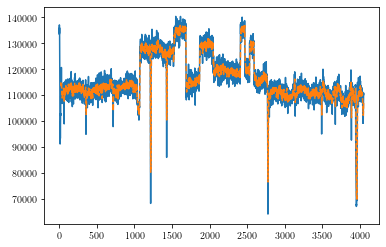

annot1:
  train: 0.5090777943777421
  test: 0.5372786999103029
annot2:
  train: 0.5090777943777421


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.521648197455581
annot3:
  train: 0.5090777943777421
  test: 0.5226567443350928
annot4:
  train: 0.5086431162102146
  test: 0.5674770099956541
annot5:


  3%|▎         | 108/4030 [00:00<00:03, 1077.51it/s]

  train: 0.4605753036212238
  test: 0.5609943425833316


100%|██████████| 4030/4030 [00:03<00:00, 1073.14it/s]


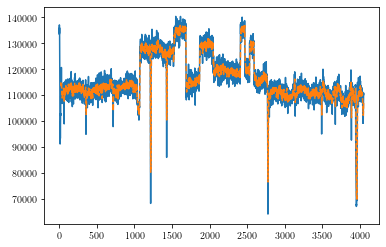

annot1:
  train: 0.5090777943777421
  test: 0.5372786999103029
annot2:
  train: 0.5090777943777421
  test: 0.521648197455581
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.5090777943777421
  test: 0.5226567443350928
annot4:
  train: 0.5086431162102146
  test: 0.5674770099956541
annot5:
  train: 0.4605753036212238


  3%|▎         | 108/4030 [00:00<00:03, 1072.78it/s]

  test: 0.5609943425833316


100%|██████████| 4030/4030 [00:03<00:00, 1051.45it/s]


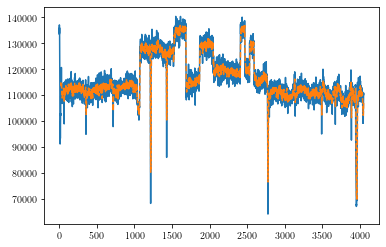

annot1:
  train: 0.5090777943777421
  test: 0.5372786999103029
annot2:
  train: 0.5090777943777421
  test: 0.521648197455581
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.5090777943777421
  test: 0.5226567443350928
annot4:
  train: 0.5086431162102146
  test: 0.5674770099956541
annot5:
  train: 0.4605753036212238


  3%|▎         | 108/4030 [00:00<00:03, 1079.07it/s]

  test: 0.5609943425833316
r = 0.5 , k = 1


100%|██████████| 4030/4030 [00:03<00:00, 1101.18it/s]


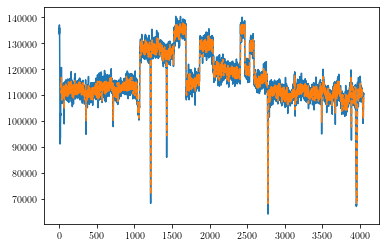

annot1:
  train: 0.47233340515251315
  test: 0.5264868483490295
annot2:
  train: 0.47233340515251315
  test: 0.520713598148242
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.47233340515251315
  test: 0.5224087023004459
annot4:
  train: 0.4724439674315322
  test: 0.530901803563668
annot5:
  train: 0.4437977353155099


  3%|▎         | 110/4030 [00:00<00:03, 1092.70it/s]

  test: 0.5289242501496727


100%|██████████| 4030/4030 [00:03<00:00, 1061.95it/s]


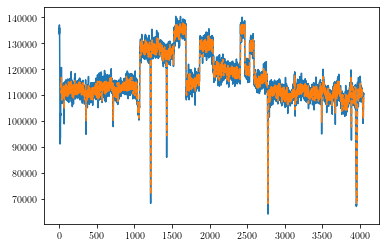

annot1:
  train: 0.47233340515251315
  test: 0.5264868483490295
annot2:
  train: 0.47233340515251315


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.520713598148242
annot3:
  train: 0.47233340515251315
  test: 0.5224087023004459
annot4:
  train: 0.4724439674315322
  test: 0.530901803563668
annot5:


  2%|▏         | 100/4030 [00:00<00:03, 994.84it/s]

  train: 0.4437977353155099
  test: 0.5289242501496727


100%|██████████| 4030/4030 [00:03<00:00, 1027.25it/s]


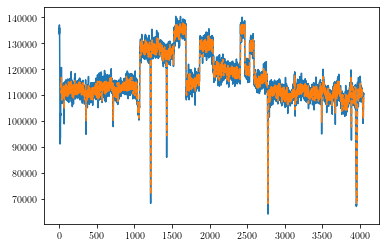

annot1:
  train: 0.47233340515251315
  test: 0.5264868483490295
annot2:
  train: 0.47233340515251315


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.520713598148242
annot3:
  train: 0.47233340515251315
  test: 0.5224087023004459
annot4:
  train: 0.4724439674315322
  test: 0.530901803563668
annot5:


  2%|▏         | 95/4030 [00:00<00:04, 946.63it/s]

  train: 0.4437977353155099
  test: 0.5289242501496727


100%|██████████| 4030/4030 [00:04<00:00, 989.79it/s] 


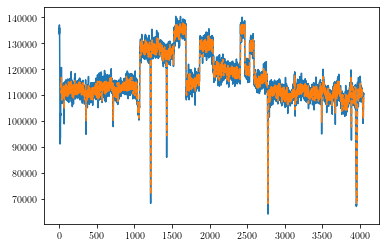

annot1:
  train: 0.47233340515251315
  test: 0.5264868483490295
annot2:
  train: 0.47233340515251315


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.520713598148242
annot3:
  train: 0.47233340515251315
  test: 0.5224087023004459
annot4:
  train: 0.4724439674315322
  test: 0.530901803563668
annot5:


  2%|▏         | 98/4030 [00:00<00:04, 975.95it/s]

  train: 0.4437977353155099
  test: 0.5289242501496727


100%|██████████| 4030/4030 [00:03<00:00, 1009.02it/s]


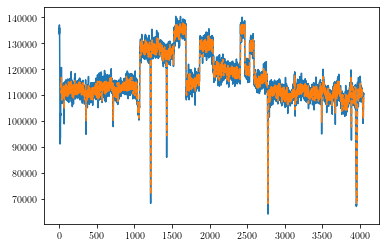

annot1:
  train: 0.47233340515251315
  test: 0.5264868483490295
annot2:
  train: 0.47233340515251315


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.520713598148242
annot3:
  train: 0.47233340515251315
  test: 0.5224087023004459
annot4:
  train: 0.4724439674315322
  test: 0.530901803563668
annot5:


  2%|▏         | 100/4030 [00:00<00:03, 998.10it/s]

  train: 0.4437977353155099
  test: 0.5289242501496727


100%|██████████| 4030/4030 [00:03<00:00, 1015.28it/s]


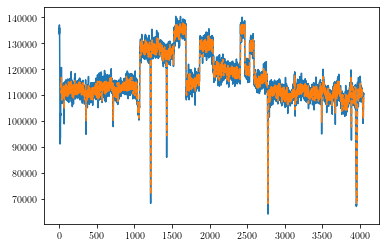

annot1:
  train: 0.47233340515251315
  test: 0.5264868483490295
annot2:
  train: 0.47233340515251315


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.520713598148242
annot3:
  train: 0.47233340515251315
  test: 0.5224087023004459
annot4:
  train: 0.4724439674315322
  test: 0.530901803563668
annot5:


  3%|▎         | 101/4030 [00:00<00:03, 1009.82it/s]

  train: 0.4437977353155099
  test: 0.5289242501496727


100%|██████████| 4030/4030 [00:04<00:00, 1003.08it/s]


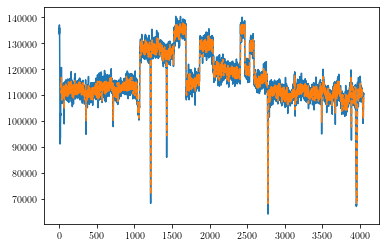

annot1:
  train: 0.47233340515251315
  test: 0.5264868483490295
annot2:
  train: 0.47233340515251315


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.520713598148242
annot3:
  train: 0.47233340515251315
  test: 0.5224087023004459
annot4:
  train: 0.4724439674315322
  test: 0.530901803563668
annot5:


  2%|▏         | 100/4030 [00:00<00:03, 995.57it/s]

  train: 0.4437977353155099
  test: 0.5289242501496727


100%|██████████| 4030/4030 [00:03<00:00, 1039.14it/s]


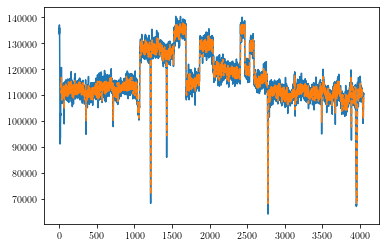

annot1:
  train: 0.47233340515251315
  test: 0.5264868483490295
annot2:
  train: 0.47233340515251315
  test: 0.520713598148242
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.47233340515251315
  test: 0.5224087023004459
annot4:
  train: 0.4724439674315322
  test: 0.530901803563668
annot5:
  train: 0.4437977353155099


  5%|▌         | 214/4030 [00:00<00:03, 1069.05it/s]

  test: 0.5289242501496727


100%|██████████| 4030/4030 [00:03<00:00, 1064.68it/s]


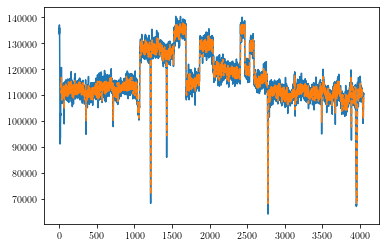

annot1:
  train: 0.47233340515251315
  test: 0.5264868483490295
annot2:
  train: 0.47233340515251315


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.520713598148242
annot3:
  train: 0.47233340515251315
  test: 0.5224087023004459
annot4:
  train: 0.4724439674315322
  test: 0.530901803563668
annot5:


  3%|▎         | 106/4030 [00:00<00:03, 1051.42it/s]

  train: 0.4437977353155099
  test: 0.5289242501496727


100%|██████████| 4030/4030 [00:03<00:00, 1051.10it/s]


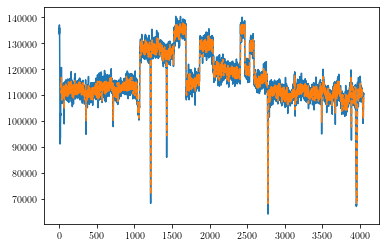

annot1:
  train: 0.47233340515251315
  test: 0.5264868483490295
annot2:
  train: 0.47233340515251315


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  test: 0.520713598148242
annot3:
  train: 0.47233340515251315
  test: 0.5224087023004459
annot4:
  train: 0.4724439674315322
  test: 0.530901803563668
annot5:
  train: 0.4437977353155099
  test: 0.5289242501496727


In [36]:
k_list = [1]
r_list = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]

res_train_annot1 = []
res_test_annot1 = []

res_train_annot2 = []
res_test_annot2 = []

res_train_annot3 = []
res_test_annot3 = []

res_train_annot4 = []
res_test_annot4 = []

res_train_annot5 = []
res_test_annot5 = []

for i, r in enumerate(r_list):
    for j, k in enumerate(k_list):
        print('r =', r, ', k =', k)
        for trial in range(10):
            seed = i*len(r_list) + j*len(k_list) + trial
            np.random.seed(seed)

            pi0 = np.array([1/k] * k).reshape(-1, 1)
            X_init = np.random.uniform(np.min(X[20:40, :]), np.max(X[20:40, :]), 20).reshape(20, X.shape[1])
            
            mu0 = [np.mean(X_init)]
            sigma0 = np.array([[np.var(X_init)]])
            theta0 = Theta(pi0, mu0, sigma0)

            scores_sem = calc_scores_sem(X, theta0, r, k, seed=seed)

            print('annot1:')
            auc_train = calc_auc_main(scores_sem, annot1-1, start=0, end=1550, T=100, N_thr=100)
            res_train_annot1.append([r, k, auc_train])
            print('  train:', auc_train)
            auc_test = calc_auc_main(scores_sem, annot1-1, start=1550, end=None, T=100, N_thr=100)
            res_test_annot1.append([r, k, auc_test])
            print('  test:', auc_test)

            print('annot2:')
            auc_train = calc_auc_main(scores_sem, annot2-1, start=0, end=1550, T=100, N_thr=100)
            res_train_annot2.append([r, k, auc_train])
            print('  train:', auc_train)
            auc_test = calc_auc_main(scores_sem, annot2-1, start=1550, end=None, T=100, N_thr=100)
            res_test_annot2.append([r, k, auc_test])
            print('  test:', auc_test)     

            print('annot3:')
            auc_train = calc_auc_main(scores_sem, annot3-1, start=0, end=1550, T=100, N_thr=100)
            res_train_annot3.append([r, k, auc_train])
            print('  train:', auc_train)
            auc_test = calc_auc_main(scores_sem, annot3-1, start=1550, end=None, T=100, N_thr=100)
            res_test_annot3.append([r, k, auc_test])
            print('  test:', auc_test)     

            print('annot4:')
            auc_train = calc_auc_main(scores_sem, annot4-1, start=0, end=1550, T=100, N_thr=100)
            res_train_annot4.append([r, k, auc_train])
            print('  train:', auc_train)
            auc_test = calc_auc_main(scores_sem, annot4-1, start=1550, end=None, T=100, N_thr=100)
            res_test_annot4.append([r, k, auc_test])
            print('  test:', auc_test)     

            print('annot5:')
            auc_train = calc_auc_main(scores_sem, annot5-1, start=0, end=1550, T=100, N_thr=100)
            res_train_annot5.append([r, k, auc_train])
            print('  train:', auc_train)
            auc_test = calc_auc_main(scores_sem, annot5-1, start=1550, end=None, T=100, N_thr=100)
            res_test_annot5.append([r, k, auc_test])
            print('  test:', auc_test)     

In [37]:
res_train_annot1_df = pd.DataFrame(res_train_annot1, columns=['r', 'k', 'AUC'])
res_test_annot1_df = pd.DataFrame(res_test_annot1, columns=['r', 'k', 'AUC'])
print(res_train_annot1_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot1_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))

             mean  std
r     k               
0.001 1  0.828013  0.0
0.003 1  0.862813  0.0
0.005 1  0.849390  0.0
0.010 1  0.808968  0.0
0.030 1  0.762015  0.0
0.050 1  0.704840  0.0
0.100 1  0.607511  0.0
0.300 1  0.509078  0.0
0.500 1  0.472333  0.0
             mean  std
r     k               
0.001 1  0.468282  0.0
0.003 1  0.779377  0.0
0.005 1  0.803912  0.0
0.010 1  0.799906  0.0
0.030 1  0.676638  0.0
0.050 1  0.632310  0.0
0.100 1  0.573190  0.0
0.300 1  0.537279  0.0
0.500 1  0.526487  0.0


In [38]:
res_train_annot2_df = pd.DataFrame(res_train_annot2, columns=['r', 'k', 'AUC'])
res_test_annot2_df = pd.DataFrame(res_test_annot2, columns=['r', 'k', 'AUC'])
print(res_train_annot2_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot2_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))

             mean  std
r     k               
0.001 1  0.828013  0.0
0.003 1  0.862813  0.0
0.005 1  0.849390  0.0
0.010 1  0.808968  0.0
0.030 1  0.762015  0.0
0.050 1  0.704840  0.0
0.100 1  0.607511  0.0
0.300 1  0.509078  0.0
0.500 1  0.472333  0.0
             mean  std
r     k               
0.001 1  0.485200  0.0
0.003 1  0.747273  0.0
0.005 1  0.775086  0.0
0.010 1  0.769908  0.0
0.030 1  0.655564  0.0
0.050 1  0.612850  0.0
0.100 1  0.547873  0.0
0.300 1  0.521648  0.0
0.500 1  0.520714  0.0


In [39]:
res_train_annot3_df = pd.DataFrame(res_train_annot3, columns=['r', 'k', 'AUC'])
res_test_annot3_df = pd.DataFrame(res_test_annot3, columns=['r', 'k', 'AUC'])
print(res_train_annot3_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot3_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))

             mean  std
r     k               
0.001 1  0.828013  0.0
0.003 1  0.862813  0.0
0.005 1  0.849390  0.0
0.010 1  0.808968  0.0
0.030 1  0.762015  0.0
0.050 1  0.704840  0.0
0.100 1  0.607511  0.0
0.300 1  0.509078  0.0
0.500 1  0.472333  0.0
             mean  std
r     k               
0.001 1  0.474784  0.0
0.003 1  0.747099  0.0
0.005 1  0.776039  0.0
0.010 1  0.771195  0.0
0.030 1  0.659043  0.0
0.050 1  0.615084  0.0
0.100 1  0.549391  0.0
0.300 1  0.522657  0.0
0.500 1  0.522409  0.0


In [40]:
res_train_annot4_df = pd.DataFrame(res_train_annot4, columns=['r', 'k', 'AUC'])
res_test_annot4_df = pd.DataFrame(res_test_annot4, columns=['r', 'k', 'AUC'])
print(res_train_annot4_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot4_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))

             mean  std
r     k               
0.001 1  0.729323  0.0
0.003 1  0.817963  0.0
0.005 1  0.824679  0.0
0.010 1  0.773846  0.0
0.030 1  0.732283  0.0
0.050 1  0.704903  0.0
0.100 1  0.620808  0.0
0.300 1  0.508643  0.0
0.500 1  0.472444  0.0
             mean  std
r     k               
0.001 1  0.502654  0.0
0.003 1  0.711053  0.0
0.005 1  0.699177  0.0
0.010 1  0.697997  0.0
0.030 1  0.680785  0.0
0.050 1  0.664443  0.0
0.100 1  0.640067  0.0
0.300 1  0.567477  0.0
0.500 1  0.530902  0.0


In [41]:
res_train_annot5_df = pd.DataFrame(res_train_annot5, columns=['r', 'k', 'AUC'])
res_test_annot5_df = pd.DataFrame(res_test_annot5, columns=['r', 'k', 'AUC'])
print(res_train_annot5_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))
print(res_test_annot5_df.groupby(['r', 'k'])['AUC'].agg(mean=np.mean, std=np.std))

             mean  std
r     k               
0.001 1  0.663447  0.0
0.003 1  0.652998  0.0
0.005 1  0.632110  0.0
0.010 1  0.592585  0.0
0.030 1  0.556537  0.0
0.050 1  0.530529  0.0
0.100 1  0.499942  0.0
0.300 1  0.460575  0.0
0.500 1  0.443798  0.0
             mean  std
r     k               
0.001 1  0.578664  0.0
0.003 1  0.646365  0.0
0.005 1  0.745019  0.0
0.010 1  0.750283  0.0
0.030 1  0.711941  0.0
0.050 1  0.673045  0.0
0.100 1  0.618802  0.0
0.300 1  0.560994  0.0
0.500 1  0.528924  0.0


## SRA

In [42]:
def sra(X, theta0, rho, gamma, t_start=50, start=20, end=40):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    pi_est = np.nan * np.ones((N, K, 1))
    mu_est = np.nan * np.ones((N, K, D))
    sigma_est = np.nan * np.ones((N, K, D, D))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(K, D)
    
    X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(20, X.shape[1])
    
    # initialization
    tau = compute_tau(X_init, theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X_init, tau)

    outliers = []
    
    inds = np.arange(N)
    
    for n in tqdm.tqdm(range(start, N)):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if ( np.any(np.isnan(tau_indiv_new)) ) | ( (n >= t_start) &  (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            
            outliers.append(n)
            
            continue
            
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()

    return pi_est, mu_est, sigma_est, outliers

In [43]:
def calc_scores_sra(X, theta0, k, gamma, ratio, M, t_start=1500, start=20, seed=0):
    np.random.seed(seed)
    
    rho = ratio * np.exp(-gamma**2/M**2) / (2.0*gamma)
    rho_const = np.repeat(rho, X.shape[0])
    pi_est, mu_est, sigma_est, outliers = sra(X, theta0, rho_const, gamma, t_start=t_start, start=start)
        
    scores = [np.nan] * start
    for t in range(start, pi_est.shape[0]):
        if t in outliers:
            score_t = np.nan
        else:
            p = np.zeros(k)
            for i in range(k):
                p_i = pi_est[t-1, i] * norm(mu_est[t-1, i, :], np.sqrt(sigma_est[t-1, i, :, :])).pdf(X[t, :])
                p[i] = p_i
            p_tot = np.sum(p)
            if p_tot >= 1e-16:
                score_t = -np.log(p_tot)
            else:
                score_t = -np.log(1e-30)
        scores.append(score_t)
    return scores

In [44]:
n_trial = 1

k_list = [1]
gamma_list = [2e6, 3e6, 4e6]

In [45]:
res_train_annot1 = []
res_test_annot1 = []

res_train_annot2 = []
res_test_annot2 = []

res_train_annot3 = []
res_test_annot3 = []

res_train_annot4 = []
res_test_annot4 = []

res_train_annot5 = []
res_test_annot5 = []

end = 1550

for i, k in enumerate(k_list):
    for j, gamma in enumerate(gamma_list):
        ratio_list = [0.01*gamma, 0.03*gamma, 0.05*gamma, 0.1*gamma]
        M_list = [gamma, 2*gamma, 4*gamma]
        for l, ratio in enumerate(ratio_list):
            for m, M in enumerate(M_list):
                for trial in range(n_trial):
                    print('k=', k, 'gamma=', gamma, ', ratio=', ratio, ', M=', M)
                    seed = i*len(k_list) + j*len(gamma_list) + l*len(ratio_list) + m * len(M_list) + trial
                    
                    np.random.seed(seed)
                    pi0 = np.random.uniform(0, 1, k)
                    pi0 /= np.sum(pi0)
                    X_init = np.random.uniform(np.min(X[20:40, :]), np.max(X[20:40, :]), 20)
                    mu0 = np.array([np.mean(X_init)])
                    sigma0 = np.array([[np.var(X_init)]])
                    theta0 = Theta(pi0, mu0, sigma0)
                    
                    scores_sra = calc_scores_sra(X, theta0, k, gamma, ratio, M, seed=seed)

                    print('annot1:')
                    auc_train = calc_auc_main(scores_sra, annot1-1, start=0, end=end, T=100, N_thr=100)
                    res_train_annot1.append([k, gamma, ratio, M, auc_train])
                    print('  train:', auc_train)
                    auc_test = calc_auc_main(scores_sra, annot1-1, start=end, end=None, T=100, N_thr=100)
                    res_test_annot1.append([k, gamma, ratio, M, auc_test])
                    print('  test:', auc_test)

                    print('annot2:')
                    auc_train = calc_auc_main(scores_sra, annot2-1, start=0, end=end, T=100, N_thr=100)
                    res_train_annot2.append([k, gamma, ratio, M, auc_train])
                    print('  train:', auc_train)
                    auc_test = calc_auc_main(scores_sra, annot2-1, start=end, end=None, T=100, N_thr=100)
                    res_test_annot2.append([k, gamma, ratio, M, auc_test])
                    print('  test:', auc_test)     

                    print('annot3:')
                    auc_train = calc_auc_main(scores_sra, annot3-1, start=0, end=end, T=100, N_thr=100)
                    res_train_annot3.append([k, gamma, ratio, M, auc_train])
                    print('  train:', auc_train)
                    auc_test = calc_auc_main(scores_sra, annot3-1, start=end, end=None, T=100, N_thr=100)
                    res_test_annot3.append([k, gamma, ratio, M, auc_test])
                    print('  test:', auc_test)     

                    print('annot4:')
                    auc_train = calc_auc_main(scores_sra, annot4-1, start=0, end=end, T=100, N_thr=100)
                    res_train_annot4.append([k, gamma, ratio, M, auc_train])
                    print('  train:', auc_train)
                    auc_test = calc_auc_main(scores_sra, annot4-1, start=end, end=None, T=100, N_thr=100)
                    res_test_annot4.append([k, gamma, ratio, M, auc_test])
                    print('  test:', auc_test)     

                    print('annot5:')
                    auc_train = calc_auc_main(scores_sra, annot5-1, start=0, end=end, T=100, N_thr=100)
                    res_train_annot5.append([k, gamma, ratio, M, auc_train])
                    print('  train:', auc_train)
                    auc_test = calc_auc_main(scores_sra, annot5-1, start=end, end=None, T=100, N_thr=100)
                    res_test_annot5.append([k, gamma, ratio, M, auc_test])
                    print('  test:', auc_test)

  0%|          | 0/4030 [00:00<?, ?it/s]

k= 1 gamma= 2000000.0 , ratio= 20000.0 , M= 2000000.0


100%|██████████| 4030/4030 [00:04<00:00, 990.95it/s] 


annot1:
  train: 0.8507717168177633
  test: 0.599788512715673
annot2:
  train: 0.8507717168177633
  test: 0.5627445039047406
annot3:


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


  train: 0.8507717168177633
  test: 0.5566541842202882
annot4:
  train: 0.7871476683937824
  test: 0.7061529335071707
annot5:
  train: 0.6596514291220237


  3%|▎         | 101/4030 [00:00<00:03, 1009.54it/s]

  test: 0.5733017224982079
k= 1 gamma= 2000000.0 , ratio= 20000.0 , M= 4000000.0


100%|██████████| 4030/4030 [00:04<00:00, 958.56it/s] 


annot1:
  train: 0.8540350461813112
  test: 0.8024015094013821
annot2:
  train: 0.8540350461813112
  test: 0.7713902485502547
annot3:
  train: 0.8540350461813112
  test: 0.7722335590994664
annot4:
  train: 0.8185100666173206
  test: 0.70658654932638
annot5:


  3%|▎         | 109/4030 [00:00<00:03, 1082.69it/s]

  train: 0.6399199196001818
  test: 0.7080793357336731
k= 1 gamma= 2000000.0 , ratio= 20000.0 , M= 8000000.0


100%|██████████| 4030/4030 [00:04<00:00, 960.66it/s] 


annot1:
  train: 0.8503814071981759
  test: 0.8069405387394342
annot2:
  train: 0.8503814071981759
  test: 0.7773406643741136
annot3:
  train: 0.8503814071981759
  test: 0.7783247514337512
annot4:
  train: 0.8215170614359735
  test: 0.7027785093437635
annot5:


  4%|▍         | 166/4030 [00:00<00:04, 856.81it/s]

  train: 0.6337230502938348
  test: 0.7442536807402282
k= 1 gamma= 2000000.0 , ratio= 60000.0 , M= 2000000.0


100%|██████████| 4030/4030 [00:04<00:00, 986.15it/s] 


annot1:
  train: 0.8440456296450634
  test: 0.8020343703801099
annot2:
  train: 0.8440456296450634
  test: 0.7735354835777111
annot3:
  train: 0.8440456296450634
  test: 0.7742366207877838
annot4:
  train: 0.8248738712065137
  test: 0.7000295089091699
annot5:


  3%|▎         | 102/4030 [00:00<00:03, 1012.56it/s]

  train: 0.62670717089175
  test: 0.743451935017814
k= 1 gamma= 2000000.0 , ratio= 60000.0 , M= 4000000.0


100%|██████████| 4030/4030 [00:03<00:00, 1050.89it/s]


annot1:
  train: 0.8048666649303788
  test: 0.784369050063674
annot2:
  train: 0.8048666649303788
  test: 0.7639166149472811
annot3:
  train: 0.8048666649303788
  test: 0.7660331491327828
annot4:
  train: 0.7666525536639526
  test: 0.6707051716644936
annot5:
  train: 0.588595620448098


  6%|▌         | 222/4030 [00:00<00:03, 1099.35it/s]

  test: 0.7535141847852262
k= 1 gamma= 2000000.0 , ratio= 60000.0 , M= 8000000.0


100%|██████████| 4030/4030 [00:03<00:00, 1065.80it/s]


annot1:
  train: 0.7949151783917398
  test: 0.7622195326461051
annot2:
  train: 0.7949151783917398
  test: 0.7450918518803419
annot3:
  train: 0.7949151783917398
  test: 0.7465944098935375
annot4:
  train: 0.760279052553664
  test: 0.6645372664059104
annot5:
  train: 0.580152589902329


  3%|▎         | 107/4030 [00:00<00:03, 1063.31it/s]

  test: 0.7536026261866662
k= 1 gamma= 2000000.0 , ratio= 100000.0 , M= 2000000.0


100%|██████████| 4030/4030 [00:03<00:00, 1028.04it/s]


annot1:
  train: 0.8120960467093006
  test: 0.7988048460159367
annot2:
  train: 0.8120960467093006
  test: 0.7655201478329432
annot3:
  train: 0.8120960467093006
  test: 0.7668619366658945
annot4:
  train: 0.779769319022946
  test: 0.7061418948283354
annot5:
  train: 0.5958777385414099


  3%|▎         | 110/4030 [00:00<00:03, 1090.90it/s]

  test: 0.7407813571751827
k= 1 gamma= 2000000.0 , ratio= 100000.0 , M= 4000000.0


100%|██████████| 4030/4030 [00:03<00:00, 1102.43it/s]


annot1:
  train: 0.774696737594026
  test: 0.7285255686080526
annot2:
  train: 0.774696737594026
  test: 0.7097566805420308
annot3:
  train: 0.774696737594026
  test: 0.7126034974303065
annot4:
  train: 0.7545754996299039
  test: 0.6799899608865709
annot5:
  train: 0.5641592958778556


  3%|▎         | 111/4030 [00:00<00:03, 1101.95it/s]

  test: 0.7382471844849916
k= 1 gamma= 2000000.0 , ratio= 100000.0 , M= 8000000.0


100%|██████████| 4030/4030 [00:03<00:00, 1113.03it/s]


annot1:
  train: 0.7724756544818719
  test: 0.7161880380706156
annot2:
  train: 0.7724756544818719
  test: 0.691858313942206
annot3:
  train: 0.7724756544818719
  test: 0.6946432227491453
annot4:
  train: 0.7533223908216136
  test: 0.6927437635810517
annot5:


  3%|▎         | 105/4030 [00:00<00:03, 1042.80it/s]

  train: 0.5628190786612153
  test: 0.7359513975668541
k= 1 gamma= 2000000.0 , ratio= 200000.0 , M= 2000000.0


100%|██████████| 4030/4030 [00:03<00:00, 1039.68it/s]


annot1:
  train: 0.7787096224284198
  test: 0.7318650016729542
annot2:
  train: 0.7787096224284198
  test: 0.7140858920588744
annot3:
  train: 0.7787096224284198
  test: 0.7170467072917991
annot4:
  train: 0.7568572908956328
  test: 0.6778652107779226
annot5:
  train: 0.5673367733871708


  3%|▎         | 106/4030 [00:00<00:03, 1052.33it/s]

  test: 0.7411450136574804
k= 1 gamma= 2000000.0 , ratio= 200000.0 , M= 4000000.0


100%|██████████| 4030/4030 [00:03<00:00, 1059.98it/s]


annot1:
  train: 0.74087248465161
  test: 0.6453967488912594
annot2:
  train: 0.74087248465161
  test: 0.6249630120437694
annot3:
  train: 0.74087248465161
  test: 0.6284021156649419
annot4:
  train: 0.7201958179126573
  test: 0.6763981964363321
annot5:
  train: 0.5495735385887714


  3%|▎         | 113/4030 [00:00<00:03, 1120.92it/s]

  test: 0.6853258230971683
k= 1 gamma= 2000000.0 , ratio= 200000.0 , M= 8000000.0


100%|██████████| 4030/4030 [00:03<00:00, 1123.20it/s]


annot1:
  train: 0.7106216541930169
  test: 0.6362413891044576
annot2:
  train: 0.7106216541930169
  test: 0.6155998440551261
annot3:
  train: 0.7106216541930169
  test: 0.618301588490281
annot4:
  train: 0.7037421539600296
  test: 0.6699078444154716
annot5:
  train: 0.5329883009776774


  3%|▎         | 114/4030 [00:00<00:03, 1133.85it/s]

  test: 0.6769521378425496
k= 1 gamma= 3000000.0 , ratio= 30000.0 , M= 3000000.0


100%|██████████| 4030/4030 [00:03<00:00, 1126.70it/s]


annot1:
  train: 0.8507717168177633
  test: 0.599788512715673
annot2:
  train: 0.8507717168177633
  test: 0.5627445039047406
annot3:
  train: 0.8507717168177633
  test: 0.5566541842202882
annot4:
  train: 0.7871476683937824
  test: 0.7061529335071707
annot5:
  train: 0.6596514291220237


  3%|▎         | 114/4030 [00:00<00:03, 1131.61it/s]

  test: 0.5733017224982079
k= 1 gamma= 3000000.0 , ratio= 30000.0 , M= 6000000.0


100%|██████████| 4030/4030 [00:03<00:00, 1071.00it/s]


annot1:
  train: 0.8540350461813112
  test: 0.8024015094013821
annot2:
  train: 0.8540350461813112
  test: 0.7713902485502547
annot3:
  train: 0.8540350461813112
  test: 0.7722335590994664
annot4:
  train: 0.8185100666173206
  test: 0.70658654932638
annot5:


  3%|▎         | 104/4030 [00:00<00:03, 1030.80it/s]

  train: 0.6399199196001818
  test: 0.7080793357336731
k= 1 gamma= 3000000.0 , ratio= 30000.0 , M= 12000000.0


100%|██████████| 4030/4030 [00:04<00:00, 969.03it/s] 


annot1:
  train: 0.8503814071981759
  test: 0.8069405387394342
annot2:
  train: 0.8503814071981759
  test: 0.7773406643741136
annot3:
  train: 0.8503814071981759
  test: 0.7783247514337512
annot4:
  train: 0.8215170614359735
  test: 0.7027785093437635
annot5:


  2%|▏         | 95/4030 [00:00<00:04, 948.83it/s]

  train: 0.6337230502938348
  test: 0.7442536807402282
k= 1 gamma= 3000000.0 , ratio= 90000.0 , M= 3000000.0


100%|██████████| 4030/4030 [00:04<00:00, 943.49it/s]


annot1:
  train: 0.8440456296450634
  test: 0.8020343703801099
annot2:
  train: 0.8440456296450634
  test: 0.7735354835777111
annot3:
  train: 0.8440456296450634
  test: 0.7742366207877838
annot4:
  train: 0.8248738712065137
  test: 0.7000295089091699
annot5:


  2%|▏         | 95/4030 [00:00<00:04, 943.31it/s]

  train: 0.62670717089175
  test: 0.743451935017814
k= 1 gamma= 3000000.0 , ratio= 90000.0 , M= 6000000.0


100%|██████████| 4030/4030 [00:04<00:00, 900.99it/s]


annot1:
  train: 0.8048666649303788
  test: 0.784369050063674
annot2:
  train: 0.8048666649303788
  test: 0.7639166149472811
annot3:
  train: 0.8048666649303788
  test: 0.7660331491327828
annot4:
  train: 0.7666525536639526
  test: 0.6707051716644936
annot5:


  2%|▏         | 98/4030 [00:00<00:04, 973.43it/s]

  train: 0.588595620448098
  test: 0.7535141847852262
k= 1 gamma= 3000000.0 , ratio= 90000.0 , M= 12000000.0


100%|██████████| 4030/4030 [00:04<00:00, 916.43it/s]


annot1:
  train: 0.7949151783917398
  test: 0.7622195326461051
annot2:
  train: 0.7949151783917398
  test: 0.7450918518803419
annot3:
  train: 0.7949151783917398
  test: 0.7465944098935375
annot4:
  train: 0.760279052553664
  test: 0.6645372664059104
annot5:


  2%|▏         | 92/4030 [00:00<00:04, 914.00it/s]

  train: 0.580152589902329
  test: 0.7536026261866662
k= 1 gamma= 3000000.0 , ratio= 150000.0 , M= 3000000.0


100%|██████████| 4030/4030 [00:04<00:00, 925.54it/s]


annot1:
  train: 0.8120960467093006
  test: 0.7988048460159367
annot2:
  train: 0.8120960467093006
  test: 0.7655201478329432
annot3:
  train: 0.8120960467093006
  test: 0.7668619366658945
annot4:
  train: 0.779769319022946


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.7061418948283354
annot5:
  train: 0.5958777385414099
  test: 0.7407813571751827
k= 1 gamma= 3000000.0 , ratio= 150000.0 , M= 6000000.0


100%|██████████| 4030/4030 [00:04<00:00, 915.70it/s]


annot1:
  train: 0.774696737594026
  test: 0.7285255686080526
annot2:
  train: 0.774696737594026
  test: 0.7097566805420308
annot3:
  train: 0.774696737594026
  test: 0.7126034974303065
annot4:
  train: 0.7545754996299039
  test: 0.6799899608865709
annot5:
  train: 0.5641592958778556


  2%|▏         | 80/4030 [00:00<00:04, 796.83it/s]

  test: 0.7382471844849916
k= 1 gamma= 3000000.0 , ratio= 150000.0 , M= 12000000.0


100%|██████████| 4030/4030 [00:05<00:00, 731.72it/s]


annot1:
  train: 0.7724756544818719
  test: 0.7161880380706156
annot2:
  train: 0.7724756544818719
  test: 0.691858313942206
annot3:
  train: 0.7724756544818719
  test: 0.6946432227491453
annot4:
  train: 0.7533223908216136
  test: 0.6927437635810517
annot5:
  train: 0.5628190786612153


  2%|▏         | 78/4030 [00:00<00:05, 773.76it/s]

  test: 0.7359513975668541
k= 1 gamma= 3000000.0 , ratio= 300000.0 , M= 3000000.0


100%|██████████| 4030/4030 [00:04<00:00, 869.62it/s]


annot1:
  train: 0.7787096224284198
  test: 0.7318650016729542
annot2:
  train: 0.7787096224284198
  test: 0.7140858920588744
annot3:
  train: 0.7787096224284198
  test: 0.7170467072917991
annot4:
  train: 0.7568572908956328
  test: 0.6778652107779226
annot5:


  3%|▎         | 101/4030 [00:00<00:03, 1009.09it/s]

  train: 0.5673367733871708
  test: 0.7411450136574804
k= 1 gamma= 3000000.0 , ratio= 300000.0 , M= 6000000.0


100%|██████████| 4030/4030 [00:04<00:00, 943.31it/s]


annot1:
  train: 0.74087248465161
  test: 0.6453967488912594
annot2:
  train: 0.74087248465161
  test: 0.6249630120437694
annot3:
  train: 0.74087248465161
  test: 0.6284021156649419
annot4:
  train: 0.7201958179126573
  test: 0.6763981964363321
annot5:


  2%|▏         | 93/4030 [00:00<00:04, 921.58it/s]

  train: 0.5495735385887714
  test: 0.6853258230971683
k= 1 gamma= 3000000.0 , ratio= 300000.0 , M= 12000000.0


100%|██████████| 4030/4030 [00:04<00:00, 954.79it/s] 


annot1:
  train: 0.7106216541930169
  test: 0.6362413891044576
annot2:
  train: 0.7106216541930169
  test: 0.6155998440551261
annot3:
  train: 0.7106216541930169
  test: 0.618301588490281
annot4:
  train: 0.7037421539600296


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.6699078444154716
annot5:
  train: 0.5329883009776774
  test: 0.6769521378425496
k= 1 gamma= 4000000.0 , ratio= 40000.0 , M= 4000000.0


100%|██████████| 4030/4030 [00:04<00:00, 983.41it/s] 


annot1:
  train: 0.8507717168177633
  test: 0.599788512715673
annot2:
  train: 0.8507717168177633
  test: 0.5627445039047406
annot3:
  train: 0.8507717168177633
  test: 0.5566541842202882
annot4:
  train: 0.7871476683937824
  test: 0.7061529335071707
annot5:
  train: 0.6596514291220237


  2%|▏         | 99/4030 [00:00<00:04, 981.45it/s]

  test: 0.5733017224982079
k= 1 gamma= 4000000.0 , ratio= 40000.0 , M= 8000000.0


100%|██████████| 4030/4030 [00:04<00:00, 952.63it/s] 


annot1:
  train: 0.8540350461813112
  test: 0.8024015094013821
annot2:
  train: 0.8540350461813112
  test: 0.7713902485502547
annot3:
  train: 0.8540350461813112
  test: 0.7722335590994664
annot4:
  train: 0.8185100666173206


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.70658654932638
annot5:
  train: 0.6399199196001818
  test: 0.7080793357336731
k= 1 gamma= 4000000.0 , ratio= 40000.0 , M= 16000000.0


100%|██████████| 4030/4030 [00:04<00:00, 822.75it/s]


annot1:
  train: 0.8503814071981759
  test: 0.8069405387394342
annot2:
  train: 0.8503814071981759
  test: 0.7773406643741136
annot3:
  train: 0.8503814071981759
  test: 0.7783247514337512
annot4:
  train: 0.8215170614359735
  test: 0.7027785093437635
annot5:


  2%|▏         | 94/4030 [00:00<00:04, 934.91it/s]

  train: 0.6337230502938348
  test: 0.7442536807402282
k= 1 gamma= 4000000.0 , ratio= 120000.0 , M= 4000000.0


100%|██████████| 4030/4030 [00:04<00:00, 919.65it/s]


annot1:
  train: 0.8440456296450634
  test: 0.8020343703801099
annot2:
  train: 0.8440456296450634
  test: 0.7735354835777111
annot3:
  train: 0.8440456296450634
  test: 0.7742366207877838
annot4:
  train: 0.8248738712065137


  2%|▏         | 97/4030 [00:00<00:04, 967.49it/s]

  test: 0.7000295089091699
annot5:
  train: 0.62670717089175
  test: 0.743451935017814
k= 1 gamma= 4000000.0 , ratio= 120000.0 , M= 8000000.0


100%|██████████| 4030/4030 [00:04<00:00, 994.21it/s] 


annot1:
  train: 0.8048666649303788
  test: 0.784369050063674
annot2:
  train: 0.8048666649303788
  test: 0.7639166149472811
annot3:
  train: 0.8048666649303788
  test: 0.7660331491327828
annot4:
  train: 0.7666525536639526
  test: 0.6707051716644936
annot5:


  3%|▎         | 101/4030 [00:00<00:03, 1008.36it/s]

  train: 0.588595620448098
  test: 0.7535141847852262
k= 1 gamma= 4000000.0 , ratio= 120000.0 , M= 16000000.0


100%|██████████| 4030/4030 [00:04<00:00, 919.72it/s]


annot1:
  train: 0.7949151783917398
  test: 0.7622195326461051
annot2:
  train: 0.7949151783917398
  test: 0.7450918518803419
annot3:
  train: 0.7949151783917398
  test: 0.7465944098935375
annot4:
  train: 0.760279052553664


  0%|          | 0/4030 [00:00<?, ?it/s]

  test: 0.6645372664059104
annot5:
  train: 0.580152589902329
  test: 0.7536026261866662
k= 1 gamma= 4000000.0 , ratio= 200000.0 , M= 4000000.0


100%|██████████| 4030/4030 [00:04<00:00, 867.88it/s]


annot1:
  train: 0.8120960467093006
  test: 0.7988048460159367
annot2:
  train: 0.8120960467093006
  test: 0.7655201478329432
annot3:
  train: 0.8120960467093006
  test: 0.7668619366658945
annot4:
  train: 0.779769319022946
  test: 0.7061418948283354
annot5:


  2%|▏         | 97/4030 [00:00<00:04, 968.42it/s]

  train: 0.5958777385414099
  test: 0.7407813571751827
k= 1 gamma= 4000000.0 , ratio= 200000.0 , M= 8000000.0


100%|██████████| 4030/4030 [00:04<00:00, 953.94it/s]


annot1:
  train: 0.774696737594026
  test: 0.7285255686080526
annot2:
  train: 0.774696737594026
  test: 0.7097566805420308
annot3:
  train: 0.774696737594026
  test: 0.7126034974303065
annot4:
  train: 0.7545754996299039
  test: 0.6799899608865709
annot5:


  2%|▏         | 95/4030 [00:00<00:04, 947.01it/s]

  train: 0.5641592958778556
  test: 0.7382471844849916
k= 1 gamma= 4000000.0 , ratio= 200000.0 , M= 16000000.0


100%|██████████| 4030/4030 [00:04<00:00, 907.98it/s]


annot1:
  train: 0.7724756544818719
  test: 0.7161880380706156
annot2:
  train: 0.7724756544818719
  test: 0.691858313942206
annot3:
  train: 0.7724756544818719
  test: 0.6946432227491453
annot4:
  train: 0.7533223908216136
  test: 0.6927437635810517
annot5:


  2%|▏         | 100/4030 [00:00<00:03, 997.30it/s]

  train: 0.5628190786612153
  test: 0.7359513975668541
k= 1 gamma= 4000000.0 , ratio= 400000.0 , M= 4000000.0


100%|██████████| 4030/4030 [00:04<00:00, 966.82it/s] 


annot1:
  train: 0.7787096224284198
  test: 0.7318650016729542
annot2:
  train: 0.7787096224284198
  test: 0.7140858920588744
annot3:
  train: 0.7787096224284198
  test: 0.7170467072917991
annot4:
  train: 0.7568572908956328
  test: 0.6778652107779226
annot5:


  2%|▏         | 97/4030 [00:00<00:04, 967.49it/s]

  train: 0.5673367733871708
  test: 0.7411450136574804
k= 1 gamma= 4000000.0 , ratio= 400000.0 , M= 8000000.0


100%|██████████| 4030/4030 [00:04<00:00, 892.59it/s]


annot1:
  train: 0.74087248465161
  test: 0.6453967488912594
annot2:
  train: 0.74087248465161
  test: 0.6249630120437694
annot3:
  train: 0.74087248465161
  test: 0.6284021156649419
annot4:
  train: 0.7201958179126573
  test: 0.6763981964363321
annot5:
  train: 0.5495735385887714
  test: 0.6853258230971683
k= 1 gamma= 4000000.0 , ratio= 400000.0 , M= 16000000.0


100%|██████████| 4030/4030 [00:05<00:00, 768.64it/s]


annot1:
  train: 0.7106216541930169
  test: 0.6362413891044576
annot2:
  train: 0.7106216541930169
  test: 0.6155998440551261
annot3:
  train: 0.7106216541930169
  test: 0.618301588490281
annot4:
  train: 0.7037421539600296
  test: 0.6699078444154716
annot5:
  train: 0.5329883009776774
  test: 0.6769521378425496


In [46]:
res_train_annot1_df = pd.DataFrame(res_train_annot1, columns=['k', 'gamma', 'ratio', 'M', 'AUC'])
res_test_annot1_df = pd.DataFrame(res_test_annot1, columns=['k', 'gamma', 'ratio', 'M', 'AUC'])
print(res_train_annot1_df.groupby(['k', 'gamma', 'ratio', 'M'])['AUC'].agg(mean=np.mean, std=np.std).sort_values(by='mean'))
print(res_test_annot1_df.groupby(['k', 'gamma', 'ratio', 'M'])['AUC'].agg(mean=np.mean, std=np.std))

                                     mean  std
k gamma     ratio    M                        
1 4000000.0 400000.0 16000000.0  0.710622  NaN
  3000000.0 300000.0 12000000.0  0.710622  NaN
  2000000.0 200000.0 8000000.0   0.710622  NaN
  3000000.0 300000.0 6000000.0   0.740872  NaN
  2000000.0 200000.0 4000000.0   0.740872  NaN
  4000000.0 400000.0 8000000.0   0.740872  NaN
            200000.0 16000000.0  0.772476  NaN
  2000000.0 100000.0 8000000.0   0.772476  NaN
  3000000.0 150000.0 12000000.0  0.772476  NaN
  4000000.0 200000.0 8000000.0   0.774697  NaN
  2000000.0 100000.0 4000000.0   0.774697  NaN
  3000000.0 150000.0 6000000.0   0.774697  NaN
  4000000.0 400000.0 4000000.0   0.778710  NaN
  2000000.0 200000.0 2000000.0   0.778710  NaN
  3000000.0 300000.0 3000000.0   0.778710  NaN
  4000000.0 120000.0 16000000.0  0.794915  NaN
  3000000.0 90000.0  12000000.0  0.794915  NaN
  2000000.0 60000.0  8000000.0   0.794915  NaN
                     4000000.0   0.804867  NaN
  4000000.0 1

In [47]:
res_train_annot2_df = pd.DataFrame(res_train_annot2, columns=['k', 'gamma', 'ratio', 'M', 'AUC'])
res_test_annot2_df = pd.DataFrame(res_test_annot2, columns=['k', 'gamma', 'ratio', 'M', 'AUC'])
print(res_train_annot2_df.groupby(['k', 'gamma', 'ratio', 'M'])['AUC'].agg(mean=np.mean, std=np.std).sort_values(by='mean'))
print(res_test_annot2_df.groupby(['k', 'gamma', 'ratio', 'M'])['AUC'].agg(mean=np.mean, std=np.std))

                                     mean  std
k gamma     ratio    M                        
1 4000000.0 400000.0 16000000.0  0.710622  NaN
  3000000.0 300000.0 12000000.0  0.710622  NaN
  2000000.0 200000.0 8000000.0   0.710622  NaN
  3000000.0 300000.0 6000000.0   0.740872  NaN
  2000000.0 200000.0 4000000.0   0.740872  NaN
  4000000.0 400000.0 8000000.0   0.740872  NaN
            200000.0 16000000.0  0.772476  NaN
  2000000.0 100000.0 8000000.0   0.772476  NaN
  3000000.0 150000.0 12000000.0  0.772476  NaN
  4000000.0 200000.0 8000000.0   0.774697  NaN
  2000000.0 100000.0 4000000.0   0.774697  NaN
  3000000.0 150000.0 6000000.0   0.774697  NaN
  4000000.0 400000.0 4000000.0   0.778710  NaN
  2000000.0 200000.0 2000000.0   0.778710  NaN
  3000000.0 300000.0 3000000.0   0.778710  NaN
  4000000.0 120000.0 16000000.0  0.794915  NaN
  3000000.0 90000.0  12000000.0  0.794915  NaN
  2000000.0 60000.0  8000000.0   0.794915  NaN
                     4000000.0   0.804867  NaN
  4000000.0 1

In [48]:
res_train_annot3_df = pd.DataFrame(res_train_annot3, columns=['k', 'gamma', 'ratio', 'M', 'AUC'])
res_test_annot3_df = pd.DataFrame(res_test_annot3, columns=['k', 'gamma', 'ratio', 'M', 'AUC'])
print(res_train_annot3_df.groupby(['k', 'gamma', 'ratio', 'M'])['AUC'].agg(mean=np.mean, std=np.std).sort_values(by='mean'))
print(res_test_annot3_df.groupby(['k', 'gamma', 'ratio', 'M'])['AUC'].agg(mean=np.mean, std=np.std))

                                     mean  std
k gamma     ratio    M                        
1 4000000.0 400000.0 16000000.0  0.710622  NaN
  3000000.0 300000.0 12000000.0  0.710622  NaN
  2000000.0 200000.0 8000000.0   0.710622  NaN
  3000000.0 300000.0 6000000.0   0.740872  NaN
  2000000.0 200000.0 4000000.0   0.740872  NaN
  4000000.0 400000.0 8000000.0   0.740872  NaN
            200000.0 16000000.0  0.772476  NaN
  2000000.0 100000.0 8000000.0   0.772476  NaN
  3000000.0 150000.0 12000000.0  0.772476  NaN
  4000000.0 200000.0 8000000.0   0.774697  NaN
  2000000.0 100000.0 4000000.0   0.774697  NaN
  3000000.0 150000.0 6000000.0   0.774697  NaN
  4000000.0 400000.0 4000000.0   0.778710  NaN
  2000000.0 200000.0 2000000.0   0.778710  NaN
  3000000.0 300000.0 3000000.0   0.778710  NaN
  4000000.0 120000.0 16000000.0  0.794915  NaN
  3000000.0 90000.0  12000000.0  0.794915  NaN
  2000000.0 60000.0  8000000.0   0.794915  NaN
                     4000000.0   0.804867  NaN
  4000000.0 1

In [49]:
res_train_annot4_df = pd.DataFrame(res_train_annot4, columns=['k', 'gamma', 'ratio', 'M', 'AUC'])
res_test_annot4_df = pd.DataFrame(res_test_annot4, columns=['k', 'gamma', 'ratio', 'M', 'AUC'])
print(res_train_annot4_df.groupby(['k', 'gamma', 'ratio', 'M'])['AUC'].agg(mean=np.mean, std=np.std).sort_values(by='mean'))
print(res_test_annot4_df.groupby(['k', 'gamma', 'ratio', 'M'])['AUC'].agg(mean=np.mean, std=np.std))

                                     mean  std
k gamma     ratio    M                        
1 4000000.0 400000.0 16000000.0  0.703742  NaN
  3000000.0 300000.0 12000000.0  0.703742  NaN
  2000000.0 200000.0 8000000.0   0.703742  NaN
  3000000.0 300000.0 6000000.0   0.720196  NaN
  2000000.0 200000.0 4000000.0   0.720196  NaN
  4000000.0 400000.0 8000000.0   0.720196  NaN
            200000.0 16000000.0  0.753322  NaN
  2000000.0 100000.0 8000000.0   0.753322  NaN
  3000000.0 150000.0 12000000.0  0.753322  NaN
  4000000.0 200000.0 8000000.0   0.754575  NaN
  2000000.0 100000.0 4000000.0   0.754575  NaN
  3000000.0 150000.0 6000000.0   0.754575  NaN
  4000000.0 400000.0 4000000.0   0.756857  NaN
  2000000.0 200000.0 2000000.0   0.756857  NaN
  3000000.0 300000.0 3000000.0   0.756857  NaN
  4000000.0 120000.0 16000000.0  0.760279  NaN
  3000000.0 90000.0  12000000.0  0.760279  NaN
  2000000.0 60000.0  8000000.0   0.760279  NaN
  3000000.0 90000.0  6000000.0   0.766653  NaN
  4000000.0 1

In [50]:
res_train_annot5_df = pd.DataFrame(res_train_annot5, columns=['k', 'gamma', 'ratio', 'M', 'AUC'])
res_test_annot5_df = pd.DataFrame(res_test_annot5, columns=['k', 'gamma', 'ratio', 'M', 'AUC'])
print(res_train_annot5_df.groupby(['k', 'gamma', 'ratio', 'M'])['AUC'].agg(mean=np.mean, std=np.std).sort_values(by='mean'))
print(res_test_annot5_df.groupby(['k', 'gamma', 'ratio', 'M'])['AUC'].agg(mean=np.mean, std=np.std))

                                     mean  std
k gamma     ratio    M                        
1 4000000.0 400000.0 16000000.0  0.532988  NaN
  3000000.0 300000.0 12000000.0  0.532988  NaN
  2000000.0 200000.0 8000000.0   0.532988  NaN
  3000000.0 300000.0 6000000.0   0.549574  NaN
  2000000.0 200000.0 4000000.0   0.549574  NaN
  4000000.0 400000.0 8000000.0   0.549574  NaN
            200000.0 16000000.0  0.562819  NaN
  2000000.0 100000.0 8000000.0   0.562819  NaN
  3000000.0 150000.0 12000000.0  0.562819  NaN
  4000000.0 200000.0 8000000.0   0.564159  NaN
  2000000.0 100000.0 4000000.0   0.564159  NaN
  3000000.0 150000.0 6000000.0   0.564159  NaN
  4000000.0 400000.0 4000000.0   0.567337  NaN
  2000000.0 200000.0 2000000.0   0.567337  NaN
  3000000.0 300000.0 3000000.0   0.567337  NaN
  4000000.0 120000.0 16000000.0  0.580153  NaN
  3000000.0 90000.0  12000000.0  0.580153  NaN
  2000000.0 60000.0  8000000.0   0.580153  NaN
                     4000000.0   0.588596  NaN
  4000000.0 1

## Summary

100%|██████████| 4050/4050 [00:01<00:00, 2957.34it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
100%|██████████| 4030/4030 [00:01<00:00, 3273.15it/s]


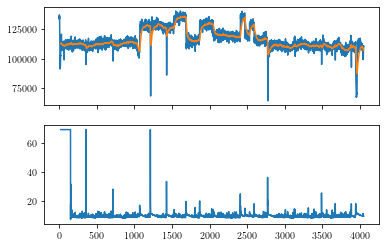

In [51]:
# SDEM
r = 0.05
k = 1

seed = 0
scores_sdem = calc_scores_sdem(X, r, k, alpha=1.0, seed=seed)

alpha = 1.0
n_cluster = 1
rho_const = np.repeat([r], X.shape[0])
sdem = SDEM(rho_const, alpha, n_components=n_cluster)

start, end = 20, 40
X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])

sdem.fit(X_init)

for t in tqdm.tqdm(range(start, X.shape[0])):
    sdem.update(X[t, :])

pi_est_sdem = np.hstack(([np.nan]*start, np.array(sdem.pi_list).ravel()))
mu_est_sdem = np.hstack(([np.nan]*start, np.array(sdem.means_bar_list).ravel()))
sigma_est_sdem = np.hstack(([np.nan]*start, np.array(sdem.covariances_list).ravel()))
        
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(np.arange(1, len(X)+1), X)
axes[0].plot(np.arange(1, len(X)+1), mu_est_sdem.ravel())
axes[1].plot(scores_sdem)
plt.show()

100%|██████████| 4030/4030 [00:01<00:00, 3034.60it/s]


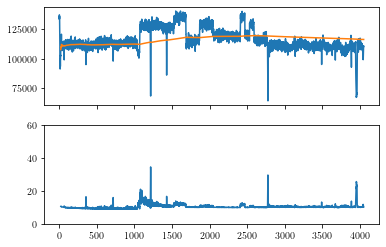

In [52]:
# IEM
k = 1

seed = 0
scores_iem = calc_scores_iem(X, k, alpha=1.0, seed=seed)

alpha = 1.0
n_cluster = 1
rho_const = 1.0 / np.arange(1, len(X)+1)
iem = SDEM(rho_const, alpha, n_components=n_cluster)

start, end = 20, 40
X_init = np.random.uniform(np.min(X[start:end, :]), np.max(X[start:end, :]), 20).reshape(-1, X.shape[1])

iem.fit(X_init)

for t in tqdm.tqdm(range(start, X.shape[0])):
    iem.update(X[t, :])

pi_est_iem = np.hstack(([np.nan]*start, np.array(iem.pi_list).ravel()))
mu_est_iem = np.hstack(([np.nan]*start, np.array(iem.means_bar_list).ravel()))
sigma_est_iem = np.array(([np.nan]*start, np.array(iem.covariances_list).ravel()))


fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(np.arange(1, len(X)+1), X)
axes[0].plot(np.arange(1, len(X)+1), mu_est_iem.ravel())
axes[1].plot(np.arange(1, len(X)+1), scores_iem)
axes[1].set_ylim(0, 60)
plt.show()

100%|██████████| 4030/4030 [00:04<00:00, 955.89it/s] 


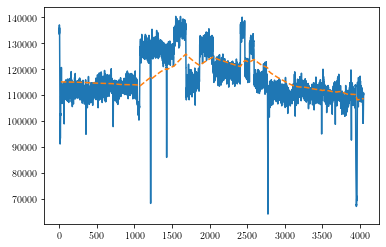

100%|██████████| 4030/4030 [00:03<00:00, 1033.55it/s]


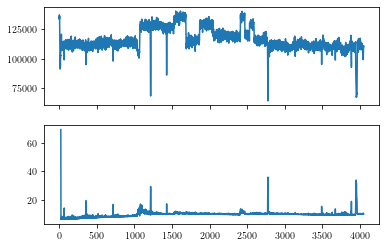

In [53]:
# sEM
r = 0.003
k = 1

start = 20

np.random.seed(5)

X_init = np.random.uniform(np.min(X[20:40, :]), np.max(X[20:40, :]), 20).reshape(20, X.shape[1])

pi0 = [1.0]
mu0 = [np.mean(X_init)]
sigma0 = np.array([[np.var(X_init)]])
theta0 = Theta(pi0, mu0, sigma0)

scores_sem = calc_scores_sem(X, theta0, r, k, start=start, seed=seed)
pi_est_sem, mu_est_sem, sigma_est_sem = sem(X, theta0, [r]*len(X), start=start, end=len(X), seed=seed)

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(X)
axes[1].plot(scores_sem)
plt.show()

In [54]:
np.set_printoptions(threshold=100000)

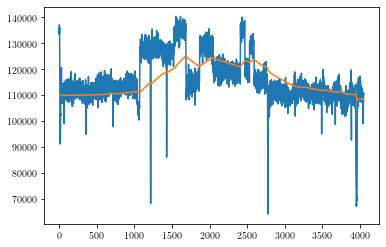

In [55]:
plt.plot(np.arange(1, len(X)+1), X.ravel())
plt.plot(np.arange(1, len(X)+1), mu_est_sem.ravel())
plt.show()

100%|██████████| 4030/4030 [00:04<00:00, 977.76it/s]


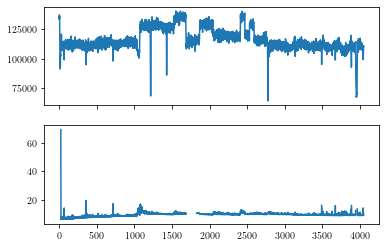

In [56]:
# SRA
k = 1
gamma = 1.5*10**4
ratio = 1.5*10**2
M = 3*10**4

np.random.seed(5)

X_init = np.random.uniform(np.min(X[20:40, :]), np.max(X[20:40, :]), 20)
mu0 = np.array([np.mean(X_init)])
sigma0 = np.array([[np.var(X_init)]])
theta0 = Theta(pi0, mu0, sigma0)

scores_sra = calc_scores_sra(X, theta0, k, gamma, ratio, M, t_start=1200, start=20, seed=0)

rho = ratio * np.exp(-gamma**2/M**2)/(2.0*gamma)

pi_est_sra, mu_est_sra, sigma_est_sra, outliers = sra(X, theta0, [rho]*len(X), gamma, t_start=1200)

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(X)
axes[1].plot(scores_sra)
plt.show()

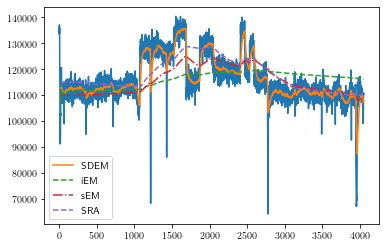

In [57]:
plt.plot(np.arange(1, len(X)+1), X.ravel())
plt.plot(np.arange(1, len(X)+1), mu_est_sdem.ravel(), linestyle='-', label='SDEM')
plt.plot(np.arange(1, len(X)+1), mu_est_iem.ravel(), linestyle='--', label='iEM')
plt.plot(np.arange(1, len(X)+1), mu_est_sem.ravel(), linestyle='-.', label='sEM')
plt.plot(np.arange(1, len(X)+1), mu_est_sra.ravel(), linestyle='--', label='SRA')
plt.legend(loc='best')
plt.show()

In [58]:
tseries_df = pd.DataFrame({'time': np.arange(1, len(scores_sdem)+1), 
                        'X': X.ravel()})
res_sdem_df = pd.DataFrame({'time': np.arange(1, len(scores_sdem)+1), 
                         'score': scores_sdem})
res_iem_df = pd.DataFrame({'time': np.arange(1, len(scores_iem)+1),
                        'score': scores_iem})
res_sem_df = pd.DataFrame({'time': np.arange(1, len(scores_sem)+1),
                        'score': scores_sem})
res_sra_df = pd.DataFrame({'time': np.arange(1, len(scores_sra)+1),
                        'score': scores_sra})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


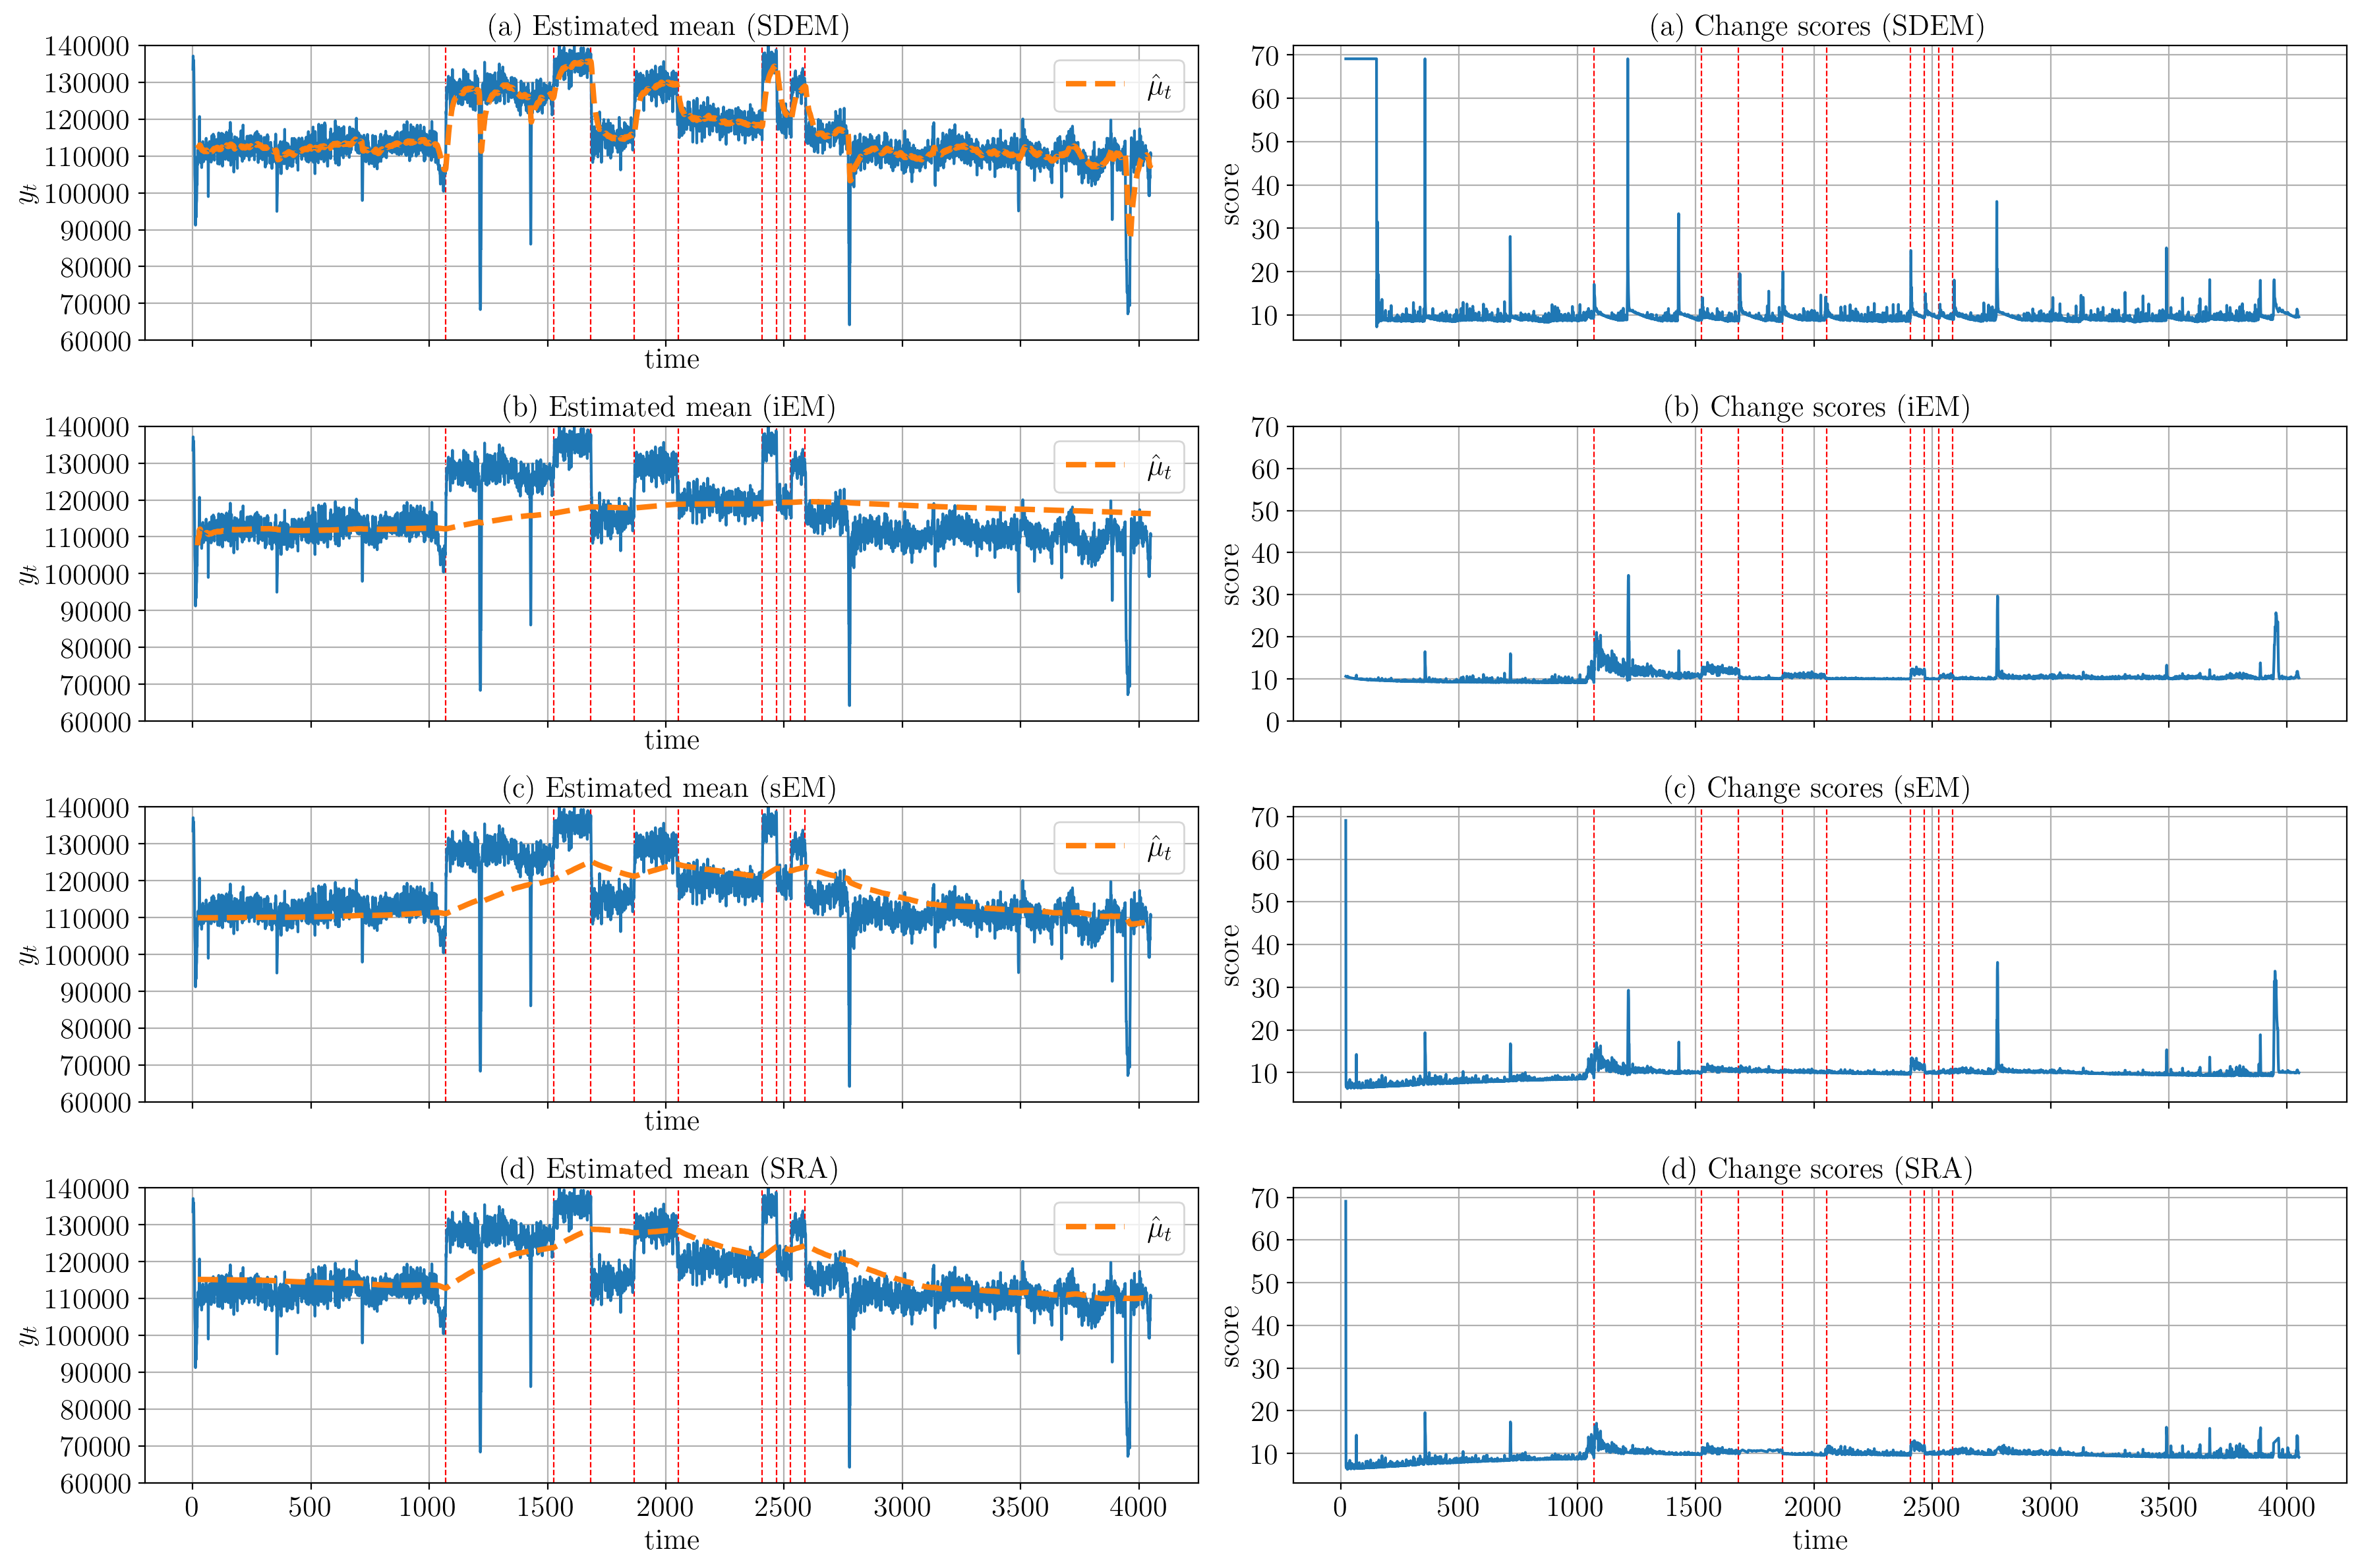

In [59]:
plt.rc('font', family='serif')

fig, axes = plt.subplots(4, 2, sharex=True, figsize=(18, 12), dpi=200)

axes[0, 0].plot(np.arange(1, len(X)+1), X.ravel(), linestyle='-')
axes[0, 0].plot(np.arange(1, len(X)+1), mu_est_sdem.ravel(), linestyle='--', label=r'$\hat{\mu}_{t}$', linewidth=3)
axes[0, 0].set_title('(a) Estimated mean (SDEM)', fontsize=16)
axes[0, 0].set_xlabel('time', fontsize=16)
axes[0, 0].set_ylabel(r'$y_{t}$', fontsize=16)
axes[0, 0].set_ylim(60000, 140000)
axes[0, 0].legend(loc='upper right', fontsize=16)
axes[0, 0].grid()

axes[1, 0].plot(np.arange(1, len(X)+1), X.ravel(), linestyle='-')
axes[1, 0].plot(np.arange(1, len(X)+1), mu_est_iem.ravel(), linestyle='--', label=r'$\hat{\mu}_{t}$', linewidth=3)
axes[1, 0].set_title('(b) Estimated mean (iEM)', fontsize=16)
axes[1, 0].set_xlabel('time', fontsize=16)
axes[1, 0].set_ylabel(r'$y_{t}$', fontsize=16)
axes[1, 0].set_ylim(60000, 140000)
axes[1, 0].legend(loc='upper right', fontsize=16)
axes[1, 0].grid()

axes[2, 0].plot(np.arange(1, len(X)+1), X.ravel(), linestyle='-')
axes[2, 0].plot(np.arange(1, len(X)+1), mu_est_sem.ravel(), linestyle='--', label=r'$\hat{\mu}_{t}$', linewidth=3)
axes[2, 0].set_title('(c) Estimated mean (sEM)', fontsize=16)
axes[2, 0].set_xlabel('time', fontsize=16)
axes[2, 0].set_ylabel(r'$y_{t}$', fontsize=16)
axes[2, 0].set_ylim(60000, 140000)
axes[2, 0].legend(loc='upper right', fontsize=16)
axes[2, 0].grid()

axes[3, 0].plot(np.arange(1, len(X)+1), X.ravel(), linestyle='-')
axes[3, 0].plot(np.arange(1, len(X)+1), mu_est_sra.ravel(), linestyle='--', label=r'$\hat{\mu}_{t}$', linewidth=3)
axes[3, 0].set_title('(d) Estimated mean (SRA)', fontsize=16)
axes[3, 0].set_xlabel('time', fontsize=16)
axes[3, 0].set_ylabel(r'$y_{t}$', fontsize=16)
axes[3, 0].set_ylim(60000, 140000)
axes[3, 0].legend(loc='upper right', fontsize=16)
axes[3, 0].grid()

sns.lineplot(data=res_sdem_df, x='time', y='score', ax=axes[0, 1])
sns.lineplot(data=res_iem_df, x='time', y='score', ax=axes[1, 1])
sns.lineplot(data=res_sem_df, x='time', y='score', ax=axes[2, 1])
sns.lineplot(data=res_sra_df, x='time', y='score', ax=axes[3, 1])

axes[0, 1].set_title('(a) Change scores (SDEM)', fontsize=16)
axes[0, 1].set_xlabel('time', fontsize=16)
axes[0, 1].set_ylabel('score', fontsize=16)
axes[0, 1].grid()

axes[1, 1].set_title('(b) Change scores (iEM)', fontsize=16)
axes[1, 1].set_ylim(0, 70)
axes[1, 1].set_xlabel('time', fontsize=16)
axes[1, 1].set_ylabel('score', fontsize=16)
axes[1, 1].grid()


axes[2, 1].set_title('(c) Change scores (sEM)', fontsize=16)
axes[2, 1].set_xlabel('time', fontsize=16)
axes[2, 1].set_ylabel('score', fontsize=16)
axes[2, 1].grid()

axes[3, 1].set_title('(d) Change scores (SRA)', fontsize=16)
axes[3, 1].set_xlabel('time', fontsize=16)
axes[3, 1].set_ylabel('score', fontsize=16)
axes[3, 1].grid()

for ax in axes.flat:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
        
    for cp in annot2:
        ax.axvline(x=cp, linestyle='dashed', linewidth=0.8, color='red', zorder=0)

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.close(6)

plt.tight_layout()
 
plt.savefig(os.path.join(outdir, 'plot_welllog_estmu_score.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'plot_welllog_estmu_score.eps'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'plot_welllog_estmu_score.png'), bbox_inches='tight')
plt.show()